# ACP Project - Model Evaluation

## Setup

In [1]:
import warnings, pickle, os
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 300)

from IPython.display import display
import matplotlib.pyplot as plt

import seaborn as sns

import shap
import optuna

%load_ext autoreload
%autoreload 1

In [2]:
from utils.evaluation import f2_score, METRICS, evaluate, evaluate_from_pred, with_sampling_strategies, spotCheckCV, spotCheckDatasets, F2TabNet, joint_plot
from utils.isolation_forest_wrapper import IsolationForestWrapper
%aimport utils.evaluation

In [3]:
from hyperparameter_tuning import tune_xgboost, tune_tabnet, tune_lgbm, tune_randomforest, tune_isolationforest, tune_logisticregression
%aimport hyperparameter_tuning

In [4]:
class Notebook:
    IMAGE_DIR = "images/critical_event_any_missing_values"
    MODEL_DIR = "models/critical_event_any_missing_values"
    OUTCOME = "CriticalEvent"
    OUTCOME_WITHIN = None

    SAVE_MODELS = True
    SAVE_IMAGES = True

    RUN_HYPERPARAMETERS = True
    HYPERPARAMETER_TIMEOUT = 60 * 60 * 2
    HYPERPARAMETER_NJOBS = 4

    SHAP_PLOTS_MAXDISPLAY = 20
    EVAL_N_RESAMPLES = 9999

    MODELS = {}
    EXPLAINERS = {}
    EVAL_RESULTS = {}
    TUNED_RESULTS = {}
    MORTALITY_RESULTS = {}
    CRITICALCARE_RESULTS = {}


In [5]:
try:
    os.makedirs(Notebook.IMAGE_DIR)
    os.makedirs(Notebook.MODEL_DIR)
except FileExistsError:
    pass


In [6]:
def restore():
    with open(f"{Notebook.MODEL_DIR}/models.bin", "rb") as file:
        Notebook.MODELS = pickle.load(file)

    with open(f"{Notebook.MODEL_DIR}/explainers.bin", "rb") as file:
        Notebook.EXPLAINERS = pickle.load(file)


### Dataset

In [7]:
from dataset import SCIData, SCICols
from utils.data_profiling import ensure_categorical_overlap, drop_exclusive_cols
%aimport dataset, utils.data_profiling

sci = (
    SCIData.load('data/sci_processed.h5')
    .fix_readmissionband()
    .derive_critical_event(within=Notebook.OUTCOME_WITHIN, return_subcols=True)
)
Notebook.OUTCOME = 'CriticalEvent'


In [8]:
from sklearn.model_selection import train_test_split

scii = (
    SCIData(sci.sort_values("AdmissionDateTime"))
    .omit_redundant()
    .drop(["ReadmissionBand", "AgeBand", "LastSpecialty"], axis=1)
    .omit_ae()
    .raw_news()
    .mandate_news()
    .augment_hsmr()
)

sci_train, sci_test = train_test_split(
    scii, test_size=0.33, random_state=42, shuffle=False
)
y_test_mortality, y_test_criticalcare = (
    sci_test.DiedWithinThreshold.copy(),
    sci_test.CriticalCare.copy(),
)

if Notebook.OUTCOME == "CriticalEvent":
    sci_train, sci_test = (
        sci_train.drop(
            ["DiedWithinThreshold", "CriticalCare"], axis=1, errors="ignore"
        ),
        sci_test.drop(["DiedWithinThreshold", "CriticalCare"], axis=1, errors="ignore"),
    )

sci_train, sci_test = SCIData(sci_train), SCIData(sci_test)

# Drop HSMR_15 as there is only 1 in the entire dataset, making a split impossible
(X_train, y_train), (X_test, y_test) = (
    sci_train.impute_blood()
    .encode_ccs_onehot()
    .xy(outcome=Notebook.OUTCOME, ordinal_encoding=True, dropna=False, fillna=True),
    sci_test.impute_blood()
    .encode_ccs_onehot()
    .xy(outcome=Notebook.OUTCOME, ordinal_encoding=True, dropna=False, fillna=True),
)
categorical_cols_idx, categorical_cols_dims = X_train.describe_categories()
drop_exclusive_cols(X_train, X_test)
ensure_categorical_overlap(X_train, X_test, categorical_cols_idx)

# Mandated vitals, Categorical diagnoses (main only)
(X_train_if, y_train_if), (X_test_if, y_test_if) = (
    sci_train.drop(SCICols.diagnoses[1:], axis=1).xy(
        outcome=Notebook.OUTCOME, ordinal_encoding=True, fillna=True
    ),
    sci_test.drop(SCICols.diagnoses[1:], axis=1).xy(
        outcome=Notebook.OUTCOME, ordinal_encoding=True, fillna=True
    ),
)
drop_exclusive_cols(X_train_if, X_test_if)

(X_train_lgbm, y_train_lgbm), (X_test_lgbm, y_test_lgbm) = (
    sci_train.encode_ccs_onehot().xy(
        outcome=Notebook.OUTCOME, ordinal_encoding=True, fillna=False
    ),
    sci_test.encode_ccs_onehot().xy(
        outcome=Notebook.OUTCOME, ordinal_encoding=True, fillna=False
    ),
)
drop_exclusive_cols(X_train_lgbm, X_test_lgbm)
ensure_categorical_overlap(X_train_lgbm, X_test_lgbm, categorical_cols_idx)

(X_train_tn, X_valid_tn, y_train_tn, y_valid_tn) = train_test_split(
    X_train.to_numpy(),
    y_train.to_numpy(),
    stratify=y_train,
    test_size=0.33,
    random_state=42,
)

(X_train_news, y_train_news), (X_test_news, y_test_news) = (
    sci_train.xy(
        outcome=Notebook.OUTCOME, x=SCICols.news_data_raw, dtype=float, fillna=True
    ),
    sci_test.xy(
        outcome=Notebook.OUTCOME, x=SCICols.news_data_raw, dtype=float, fillna=True
    ),
)
drop_exclusive_cols(X_train_news, X_test_news)


### Tuning

In [9]:
from sklearn.metrics import precision_recall_curve


def get_threshold(y_train, y_pred_proba, target=0.85):
    """ Given prediction probabilities, sets the prediction threshold to approach the given target recall
    """

    # Get candidate thresholds from the model, and find the one that gives the best fbeta score
    precision, recall, thresholds = precision_recall_curve(y_train, y_pred_proba)
    closest = thresholds[np.abs(recall - target).argmin()]

    return closest


## Models

### Baseline (NEWS)

Accuracy  Precision    Recall  F1 Score  F2 Score      AUC       AUC_CI
Model  0.927606    0.62309  0.149248  0.240814  0.176019  0.76584  0.755-0.777

array([[29283,   222],
       [ 2092,   367]])

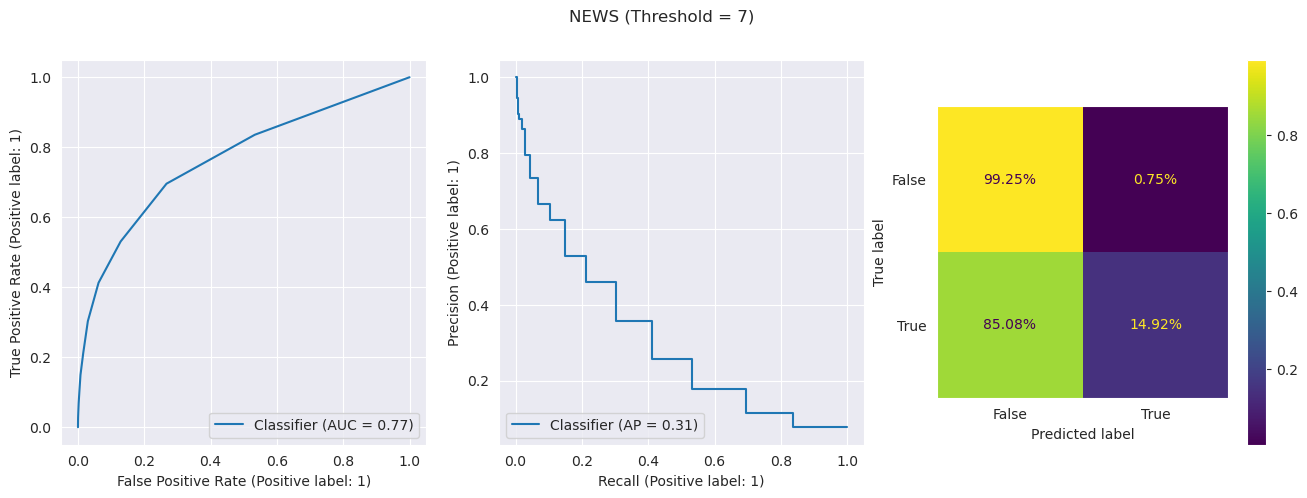

In [10]:
baseline_mask = sci[sci.c_NEWS_score.notna()].index.intersection(sci_test.index)
Notebook.EVAL_RESULTS["Baseline (NEWS)"] = evaluate_from_pred(
    y_test.loc[baseline_mask],
    y_pred=(sci.loc[baseline_mask].c_NEWS_score >= 7),
    y_pred_proba=(sci.loc[baseline_mask].c_NEWS_score),
    plot_title="NEWS (Threshold = 7)",
    save=f"{Notebook.IMAGE_DIR}/baseline_news.png" if Notebook.SAVE_IMAGES else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


Mortality


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.947159   0.466893  0.166667  0.245645  0.191264  0.765871   

            AUC_CI  
Model  0.752-0.779

array([[30000,   314],
       [ 1375,   275]])

Critical Care


Accuracy  Precision  Recall  F1 Score  F2 Score       AUC       AUC_CI
Model  0.958453   0.239389  0.1381  0.175155  0.150867  0.767118  0.751-0.783

array([[30495,   448],
       [  880,   141]])

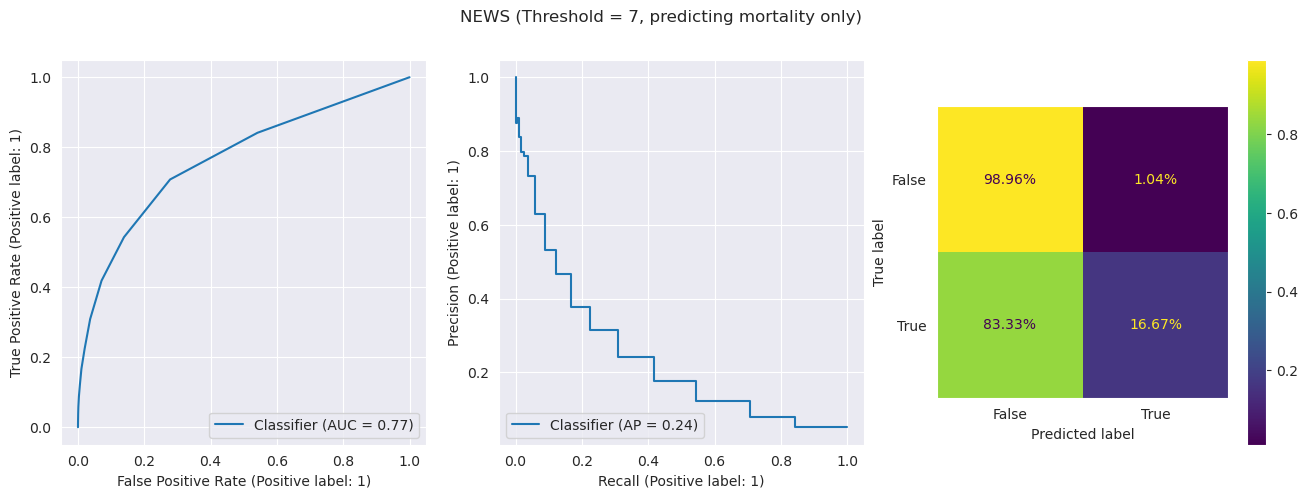

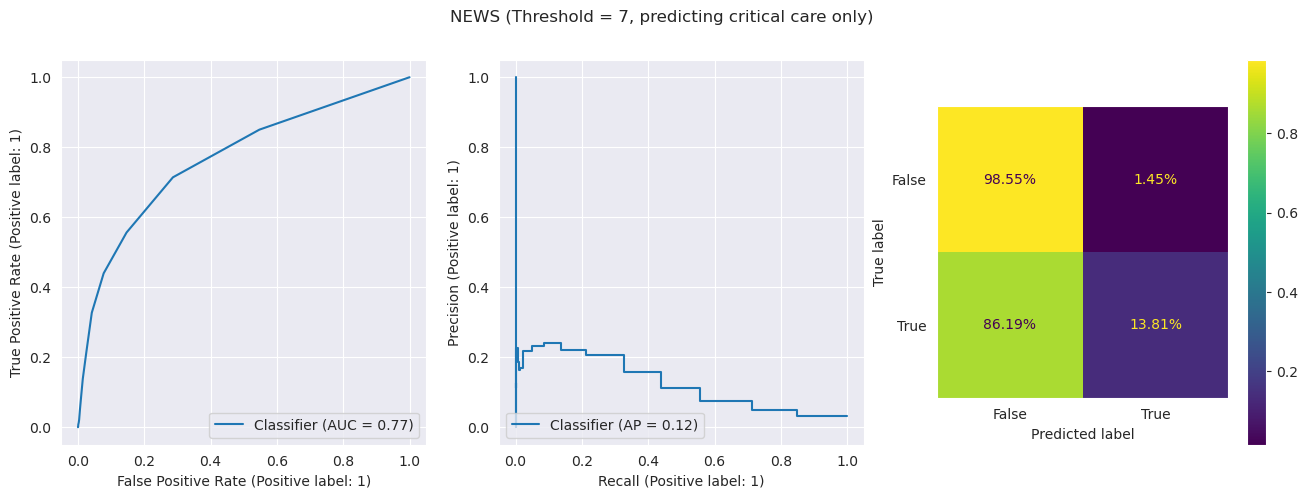

In [11]:
print("Mortality")
Notebook.MORTALITY_RESULTS["Baseline (NEWS)"] = evaluate_from_pred(
    y_test_mortality.loc[baseline_mask],
    y_pred=(sci.loc[baseline_mask].c_NEWS_score >= 7),
    y_pred_proba=(sci.loc[baseline_mask].c_NEWS_score),
    plot_title="NEWS (Threshold = 7, predicting mortality only)",
    save=f"{Notebook.IMAGE_DIR}/baseline_news_mortality.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)

print("Critical Care")
Notebook.CRITICALCARE_RESULTS["Baseline (NEWS)"] = evaluate_from_pred(
    y_test_criticalcare.loc[baseline_mask],
    y_pred=(sci.loc[baseline_mask].c_NEWS_score >= 7),
    y_pred_proba=(sci.loc[baseline_mask].c_NEWS_score),
    plot_title="NEWS (Threshold = 7, predicting critical care only)",
    save=f"{Notebook.IMAGE_DIR}/baseline_news_criticalcare.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)



### Logistic Regression (NEWS only)

Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.835033   0.249377  0.569337  0.346835  0.453074  0.774184   

            AUC_CI  
Model  0.764-0.785

array([[25291,  4214],
       [ 1059,  1400]])

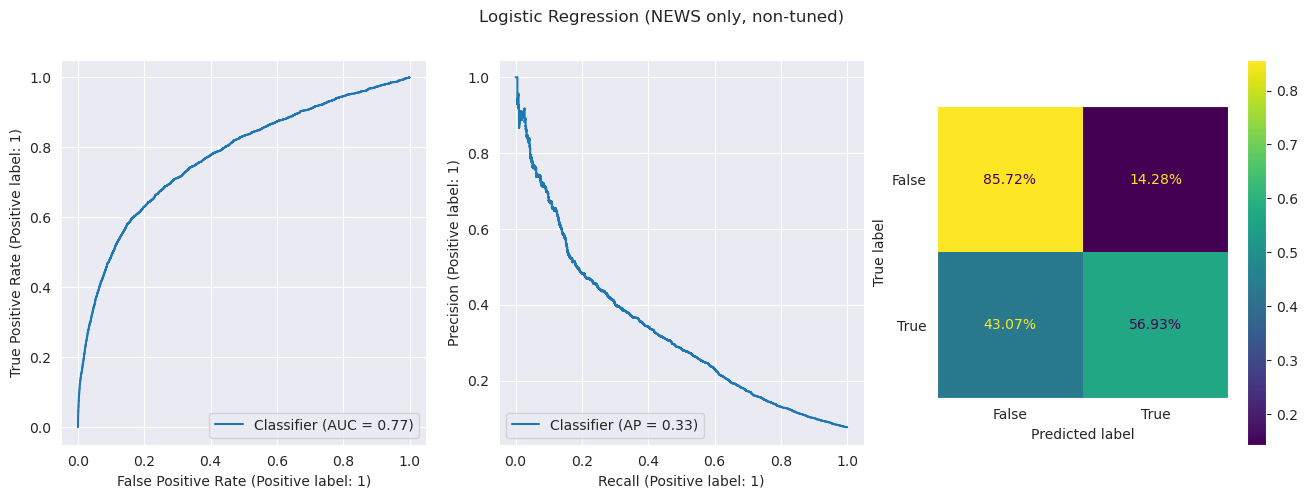

In [12]:
from sklearn.linear_model import LogisticRegression

modelkey = "Logistic Regression (NEWS only)"
model = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42).fit(
    X_train_news, y_train_news
)
Notebook.MODELS[modelkey] = model

Notebook.EVAL_RESULTS[modelkey] = evaluate(
    model,
    X_test_news,
    y_test_news,
    plot_title="Logistic Regression (NEWS only, non-tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_logistic_news.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model   0.53044   0.122715  0.830012  0.213818   0.38556  0.774184   

            AUC_CI  
Model  0.764-0.785

array([[14914, 14591],
       [  418,  2041]])

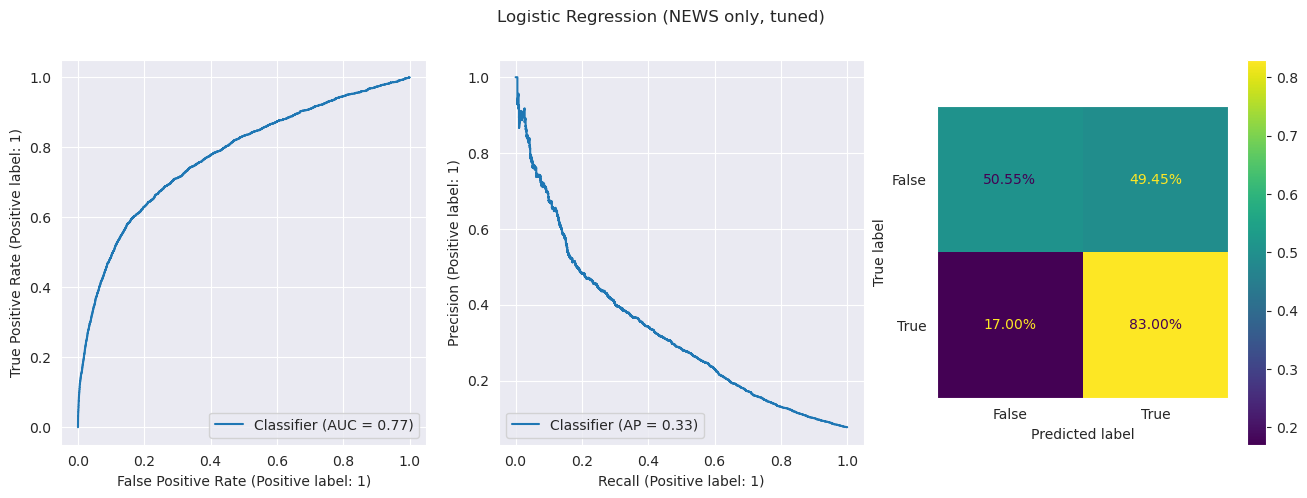

In [13]:
threshold = get_threshold(y_train_news, model.predict_proba(X_train_news)[:, 1],)

y_pred_proba = model.predict_proba(X_test_news)[:, 1]
y_pred = np.where(y_pred_proba > threshold, 1, 0)

Notebook.TUNED_RESULTS[modelkey] = evaluate_from_pred(
    y_test_news,
    y_pred,
    y_pred_proba,
    plot_title="Logistic Regression (NEWS only, tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_thresholded_logistic_news.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)



Mortality


Accuracy  Precision    Recall  F1 Score  F2 Score      AUC       AUC_CI
Model  0.514391   0.082973  0.836364  0.150968  0.297004  0.77424  0.762-0.787

array([[15062, 15252],
       [  270,  1380]])

Critical Care


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.501345   0.051527  0.839373  0.097094  0.206845  0.771664   

            AUC_CI  
Model  0.755-0.788

array([[15168, 15775],
       [  164,   857]])

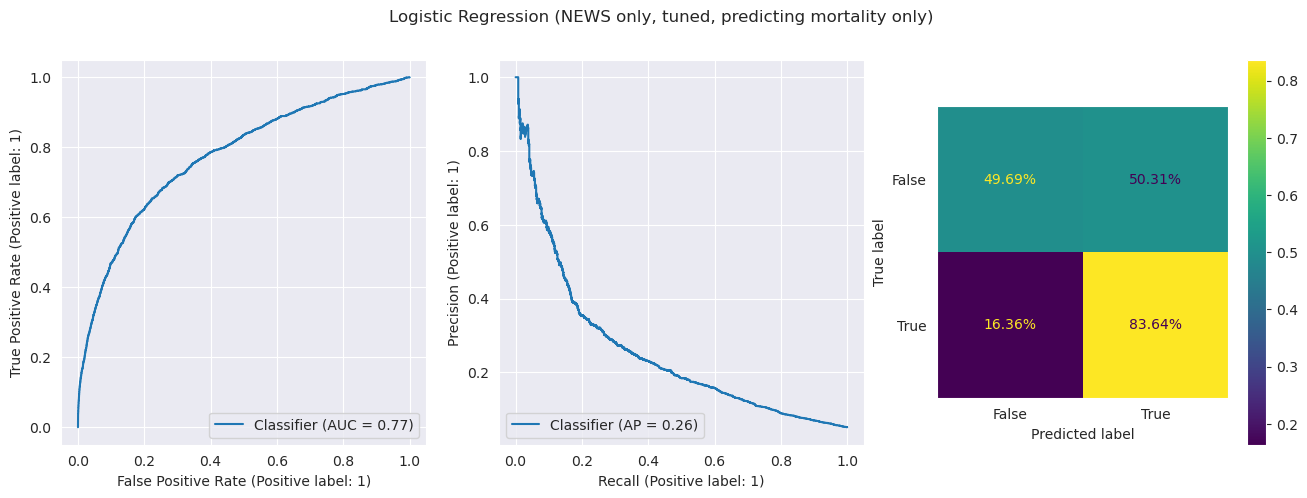

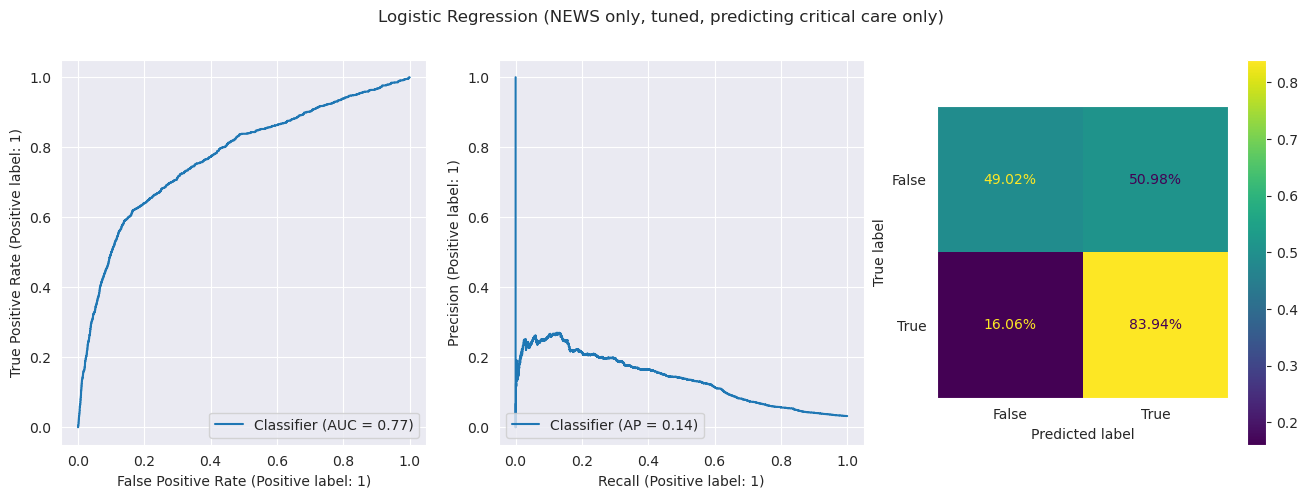

In [14]:
print("Mortality")
Notebook.MORTALITY_RESULTS[modelkey] = evaluate_from_pred(
    y_test_mortality,
    y_pred,
    y_pred_proba,
    plot_title="Logistic Regression (NEWS only, tuned, predicting mortality only)",
    save=f"{Notebook.IMAGE_DIR}/eval_mortality_thresholded_logistic_news.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)

print("Critical Care")
Notebook.CRITICALCARE_RESULTS[modelkey] = evaluate_from_pred(
    y_test_criticalcare,
    y_pred,
    y_pred_proba,
    plot_title="Logistic Regression (NEWS only, tuned, predicting critical care only)",
    save=f"{Notebook.IMAGE_DIR}/eval_criticalcare_thresholded_logistic_news.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

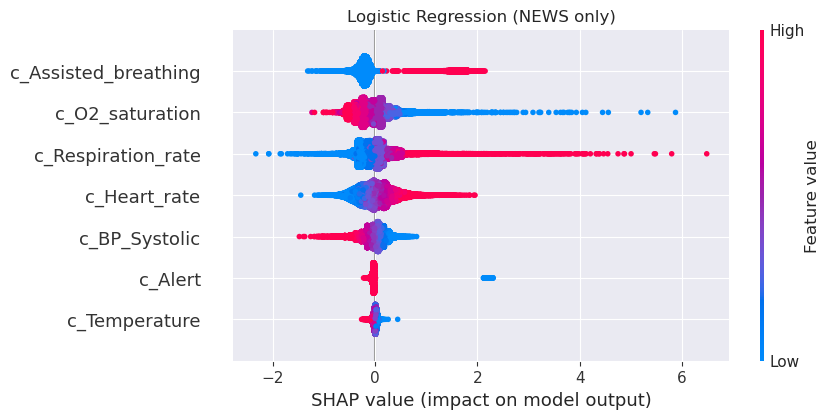

In [15]:
explainer = shap.LinearExplainer(
    model, X_train_news, feature_perturbation="correlation_dependent"
)
shap_values = explainer(X_test_news)
Notebook.EXPLAINERS[modelkey] = (explainer, shap_values)

fig = shap.plots.beeswarm(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("Logistic Regression (NEWS only)")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_swarm_logistic_regression_news.png",
        bbox_inches="tight",
    )


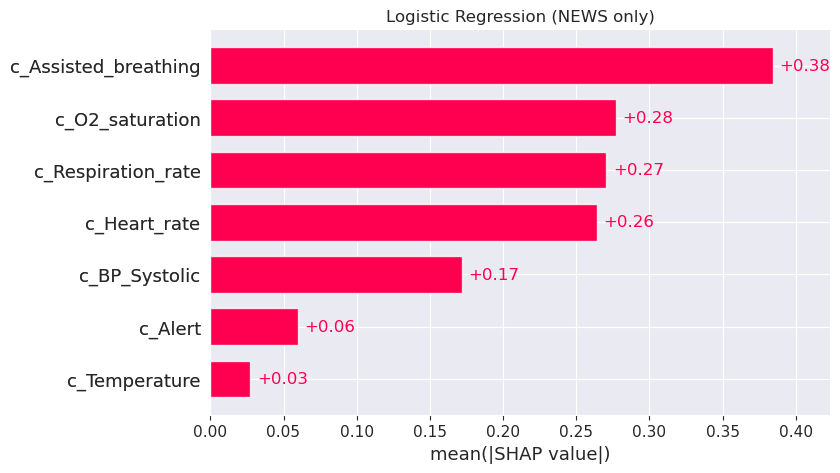

In [16]:
fig = shap.plots.bar(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("Logistic Regression (NEWS only)")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_bar_logistic_regression_news.png",
        bbox_inches="tight",
    )


### Logistic Regression

In [17]:
lr_params = {
    "LR__max_iter": 10000,
    "LR__penalty": "l2",
    "LR__solver": "lbfgs",
    "LR__C": 7.87,
    "LR__class_weight": "balanced",
    "IMB__sampling_strategy": 0.2,
}

if Notebook.RUN_HYPERPARAMETERS:
    lr_params.update(
        tune_logisticregression(
            X_train,
            y_train,
            timeout=Notebook.HYPERPARAMETER_TIMEOUT,
            n_jobs=Notebook.HYPERPARAMETER_NJOBS,
        )
    )


BEST PARAMETERS
{'LR__penalty': 'l2', 'LR__C': 5.5034736204362185, 'LR__class_weight': 'balanced', 'IMB__sampling_strategy': 0.2657375775443447}


X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.798961   0.233078  0.704351  0.350253  0.501535  0.831468   

            AUC_CI  
Model  0.822-0.840

array([[23806,  5699],
       [  727,  1732]])

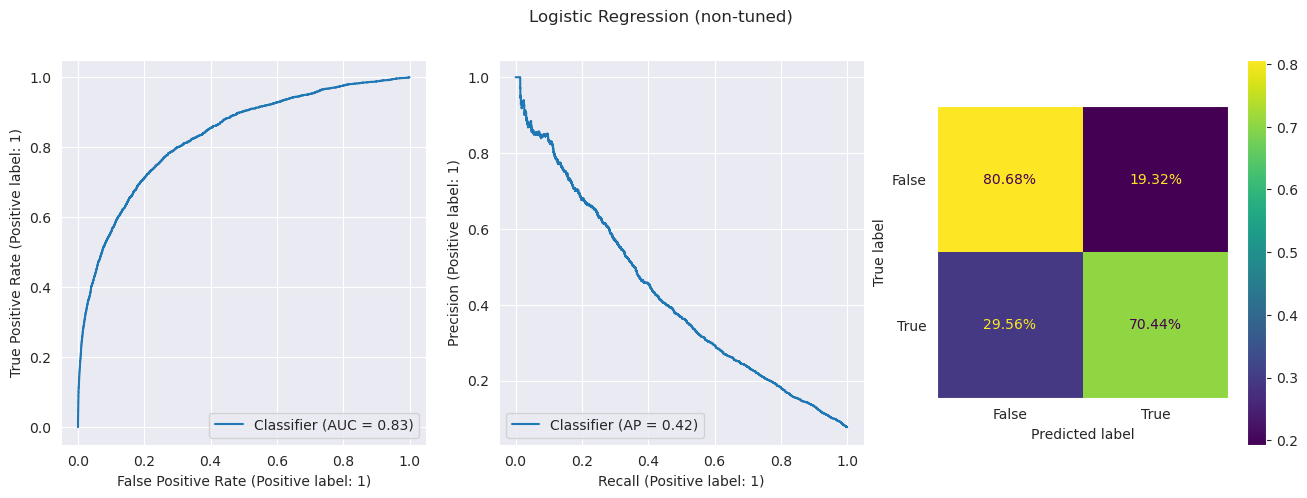

In [18]:
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

modelkey = "Logistic Regression"
model = (
    ImbPipeline(steps=[("IMB", RandomUnderSampler()), ("LR", LogisticRegression()),])
    .set_params(**lr_params)
    .fit(X_train, y_train)
)

Notebook.EVAL_RESULTS[modelkey] = evaluate(
    model,
    X_test,
    y_test,
    plot_title="Logistic Regression (non-tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_logistic_regression.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)

Notebook.MODELS[modelkey] = model


X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.651326   0.160119  0.832046  0.268557  0.452375  0.831468   

            AUC_CI  
Model  0.822-0.840

array([[18773, 10732],
       [  413,  2046]])

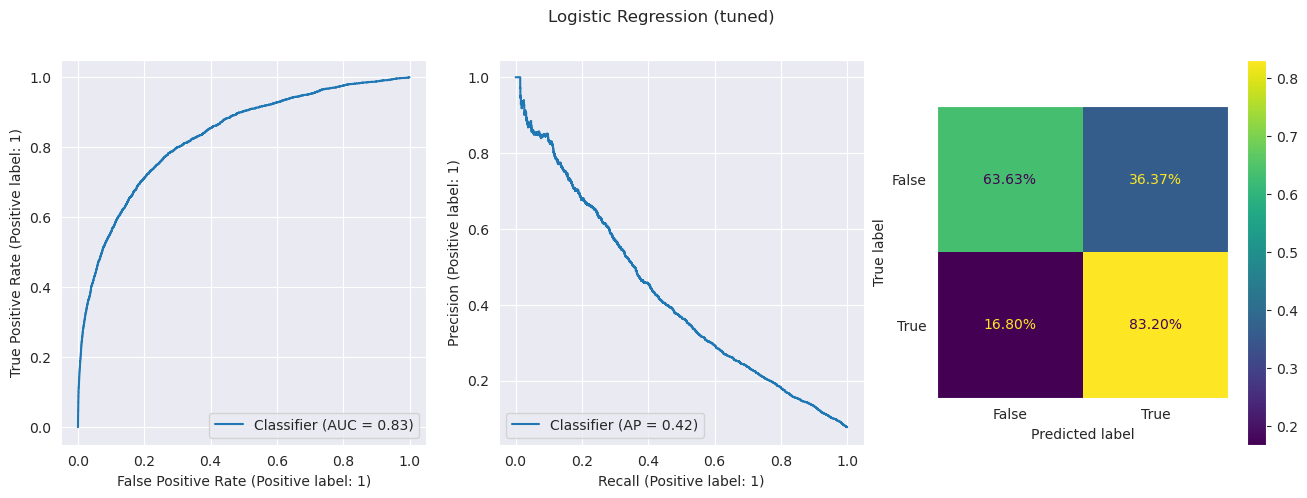

In [19]:
threshold = get_threshold(y_train, model.predict_proba(X_train)[:, 1],)

# Create predictions on the test set, using this new threshold
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = np.where(y_pred_proba > threshold, 1, 0)

# Produce scores
Notebook.TUNED_RESULTS[modelkey] = evaluate_from_pred(
    y_test,
    y_pred,
    y_pred_proba,
    plot_title="Logistic Regression (tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_thresholded_logistic_regression.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


Mortality


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model   0.63584   0.109094  0.844848  0.193235  0.359686  0.832105   

            AUC_CI  
Model  0.822-0.842

array([[18930, 11384],
       [  256,  1394]])

Critical Care


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.621042   0.065973  0.825661  0.122183   0.24997  0.818058   

            AUC_CI  
Model  0.803-0.833

array([[19008, 11935],
       [  178,   843]])

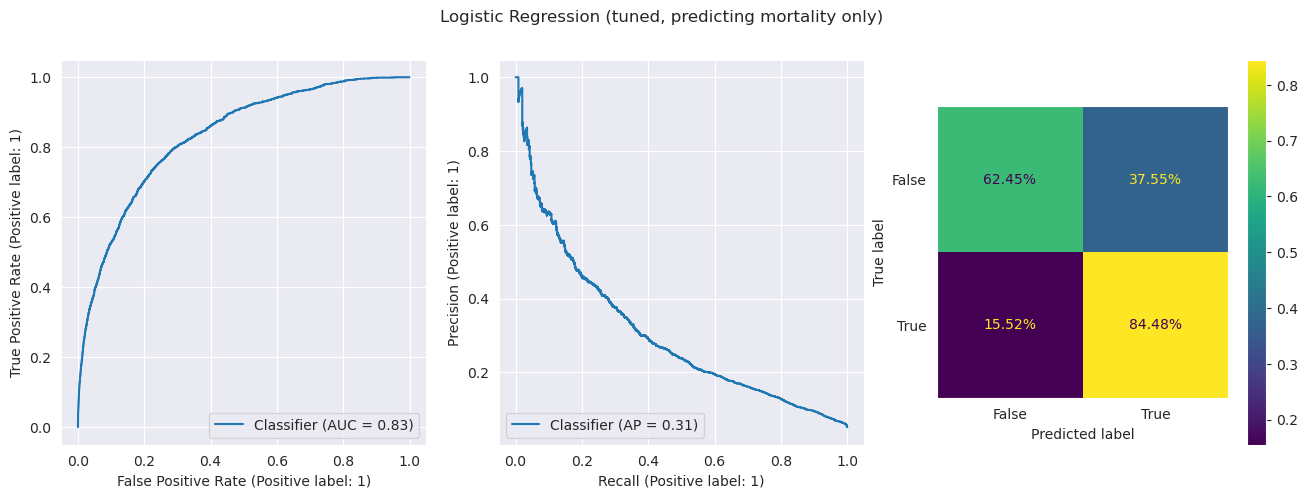

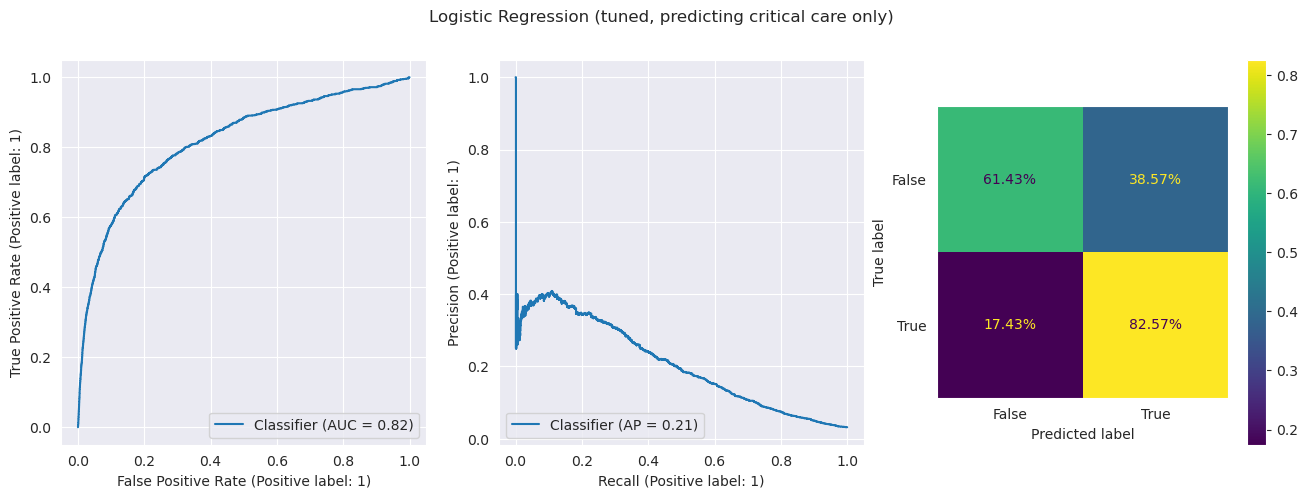

In [20]:
print("Mortality")
Notebook.MORTALITY_RESULTS[modelkey] = evaluate_from_pred(
    y_test_mortality,
    y_pred,
    y_pred_proba,
    plot_title="Logistic Regression (tuned, predicting mortality only)",
    save=f"{Notebook.IMAGE_DIR}/eval_mortality_thresholded_logistic_regression.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)

print("Critical Care")
Notebook.CRITICALCARE_RESULTS[modelkey] = evaluate_from_pred(
    y_test_criticalcare,
    y_pred,
    y_pred_proba,
    plot_title="Logistic Regression (tuned, predicting critical care only)",
    save=f"{Notebook.IMAGE_DIR}/eval_criticalcare_thresholded_logistic_regression.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

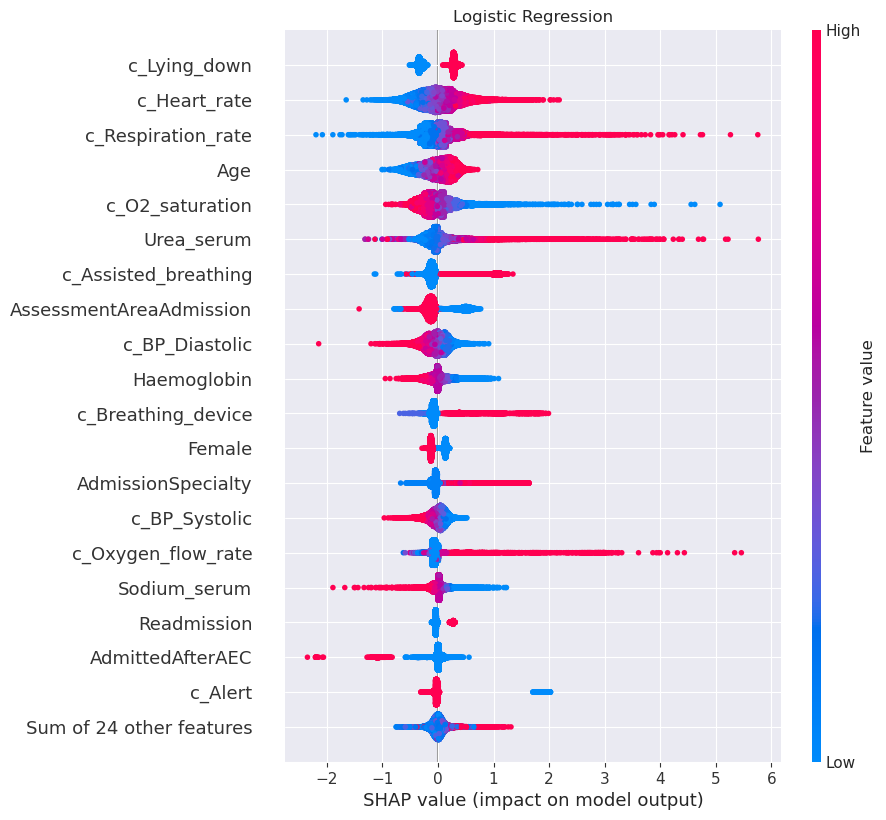

In [21]:
explainer = shap.LinearExplainer(
    model["LR"], X_train, feature_perturbation="correlation_dependent"
)
shap_values = explainer(X_test)
Notebook.EXPLAINERS[modelkey] = (explainer, shap_values)

fig = shap.plots.beeswarm(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("Logistic Regression")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_swarm_logistic_regression.png", bbox_inches="tight"
    )


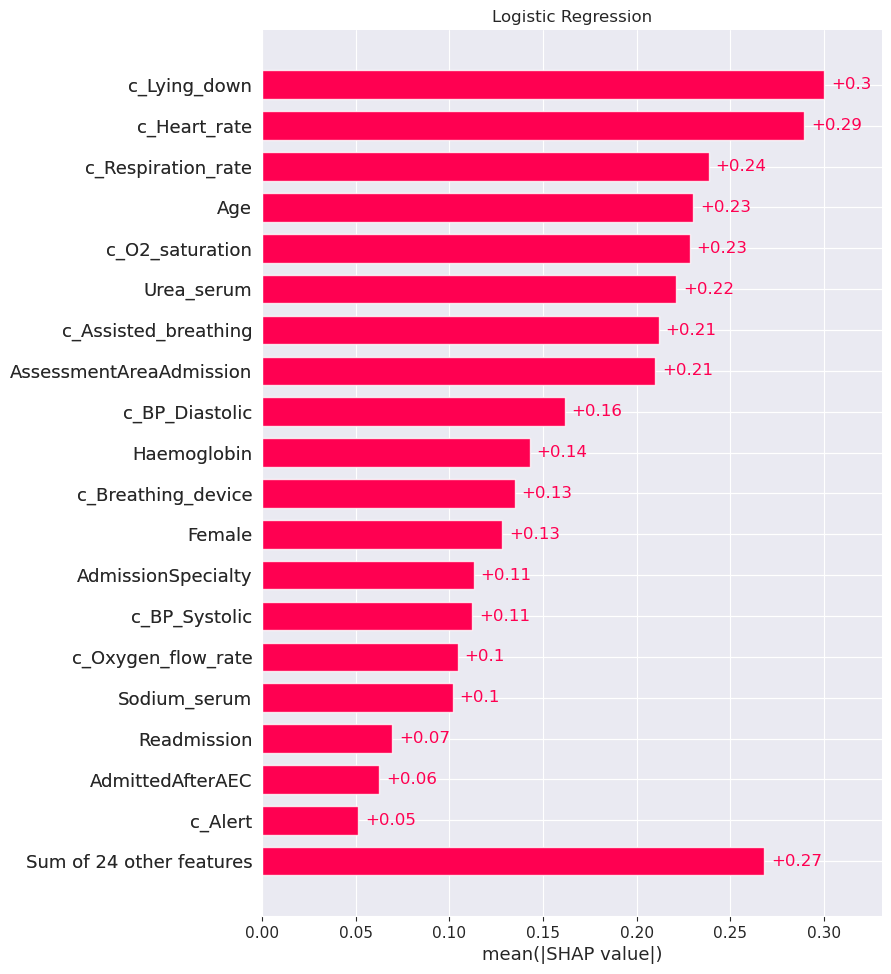

In [22]:
fig = shap.plots.bar(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("Logistic Regression")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_bar_logistic_regression.png", bbox_inches="tight"
    )


### Random Forest

In [23]:
rf_params = {
    "RF__n_estimators": 250,
    "RF__max_features": 0.56,
    "RF__min_samples_split": 8,
    "RF__min_samples_leaf": 3,
    "RF__max_samples": 0.75,
    "RF__class_weight": "balanced",
    "IMB__sampling_strategy": 0.14,
}

if Notebook.RUN_HYPERPARAMETERS:
    rf_params.update(
        tune_randomforest(
            X_train,
            y_train,
            timeout=Notebook.HYPERPARAMETER_TIMEOUT,
            n_jobs=Notebook.HYPERPARAMETER_NJOBS,
        )
    )



BEST PARAMETERS
{'RF__n_estimators': 250, 'RF__max_features': 0.2265740776397867, 'RF__min_samples_split': 14, 'RF__min_samples_leaf': 6, 'RF__max_samples': 0.7258826333130953, 'RF__class_weight': 'balanced', 'IMB__sampling_strategy': 0.11144346718652091}


Accuracy  Precision   Recall  F1 Score  F2 Score       AUC       AUC_CI
Model  0.915843   0.454039  0.46401   0.45897  0.461981  0.851465  0.843-0.860

array([[28133,  1372],
       [ 1318,  1141]])

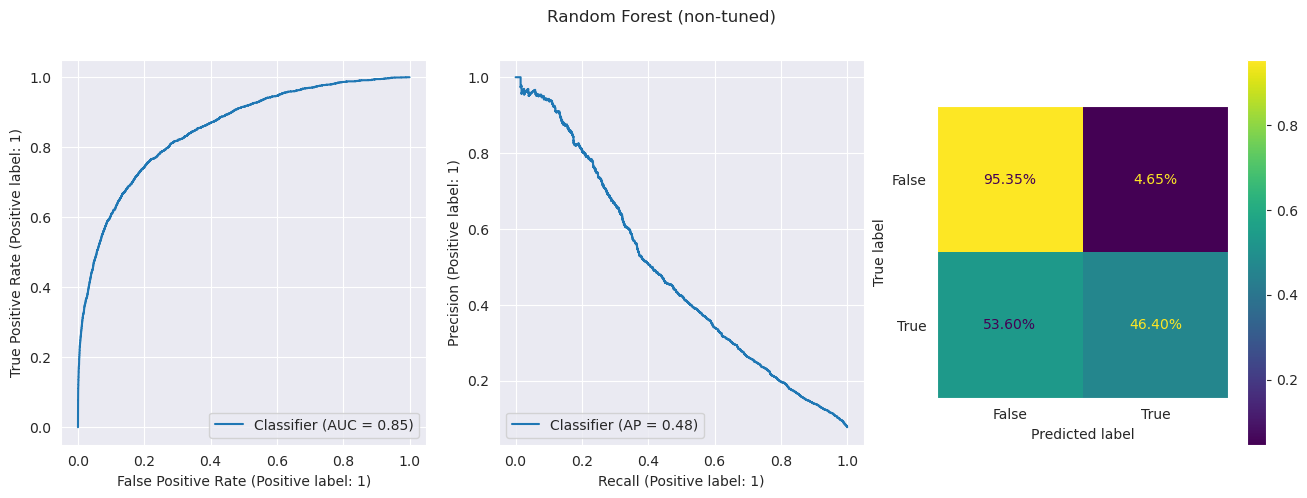

In [24]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

modelkey = "Random Forest"
model = (
    ImbPipeline(steps=[("IMB", RandomUnderSampler()), ("RF", RandomForestClassifier())])
    .set_params(**rf_params)
    .fit(X_train.to_numpy(), y_train)
)

Notebook.MODELS[modelkey] = model

Notebook.EVAL_RESULTS[modelkey] = evaluate(
    model,
    X_test.to_numpy(),
    y_test,
    plot_title="Random Forest (non-tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_random_forest.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)



Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.919441   0.474628  0.441236  0.457323  0.447533  0.851465   

            AUC_CI  
Model  0.843-0.860

array([[28304,  1201],
       [ 1374,  1085]])

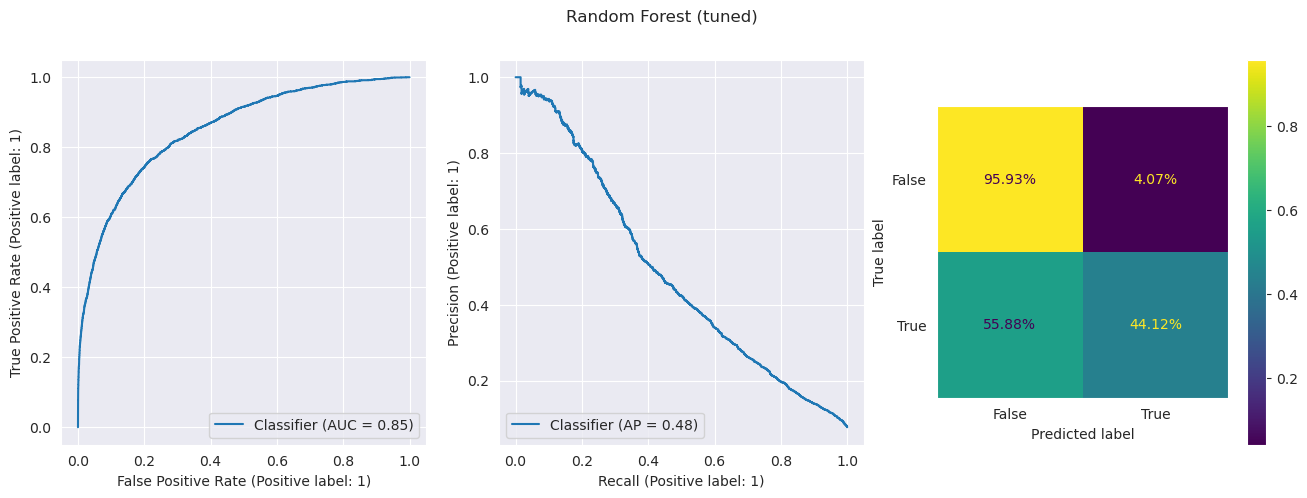

In [25]:
threshold = get_threshold(y_train, model.predict_proba(X_train.to_numpy())[:, 1],)

# Create predictions on the test set, using this new threshold
y_pred_proba = model.predict_proba(X_test.to_numpy())[:, 1]
y_pred = np.where(y_pred_proba > 1 - threshold, 1, 0)

# Produce scores
Notebook.TUNED_RESULTS[modelkey] = evaluate_from_pred(
    y_test,
    y_pred,
    y_pred_proba,
    plot_title="Random Forest (tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_thresholded_random_forest.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


Mortality


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.919597   0.298775  0.413939  0.347053  0.384312  0.839977   

            AUC_CI  
Model  0.830-0.849

array([[28711,  1603],
       [  967,   683]])

Critical Care


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.930516   0.237533  0.531832  0.328394  0.426217  0.855308   

            AUC_CI  
Model  0.842-0.868

array([[29200,  1743],
       [  478,   543]])

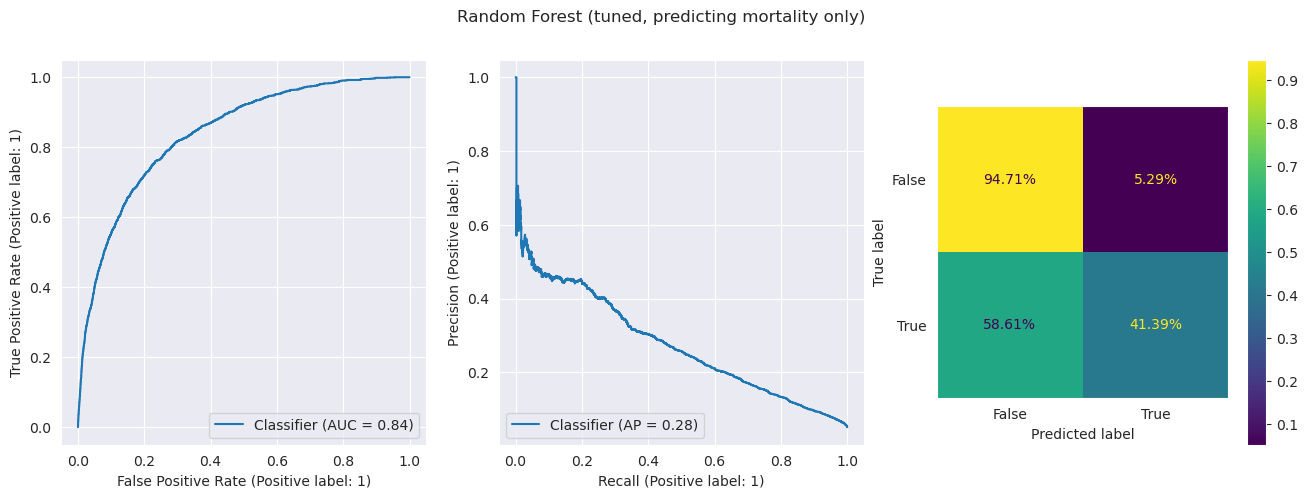

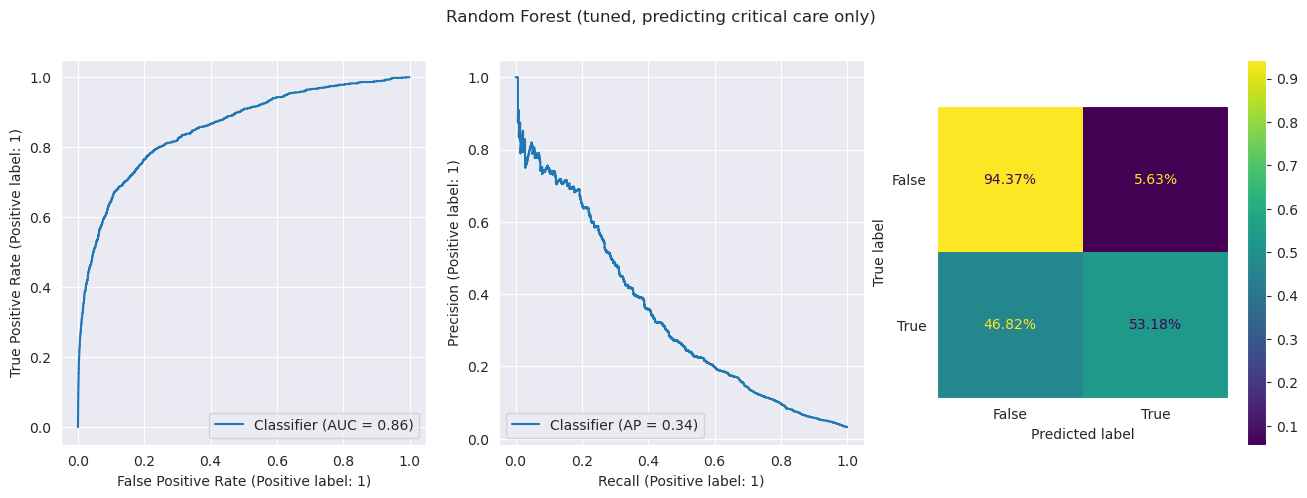

In [26]:
print("Mortality")
Notebook.MORTALITY_RESULTS[modelkey] = evaluate_from_pred(
    y_test_mortality,
    y_pred,
    y_pred_proba,
    plot_title="Random Forest (tuned, predicting mortality only)",
    save=f"{Notebook.IMAGE_DIR}/eval_mortality_thresholded_random_forest.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)

print("Critical Care")
Notebook.CRITICALCARE_RESULTS[modelkey] = evaluate_from_pred(
    y_test_criticalcare,
    y_pred,
    y_pred_proba,
    plot_title="Random Forest (tuned, predicting critical care only)",
    save=f"{Notebook.IMAGE_DIR}/eval_criticalcare_thresholded_random_forest.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


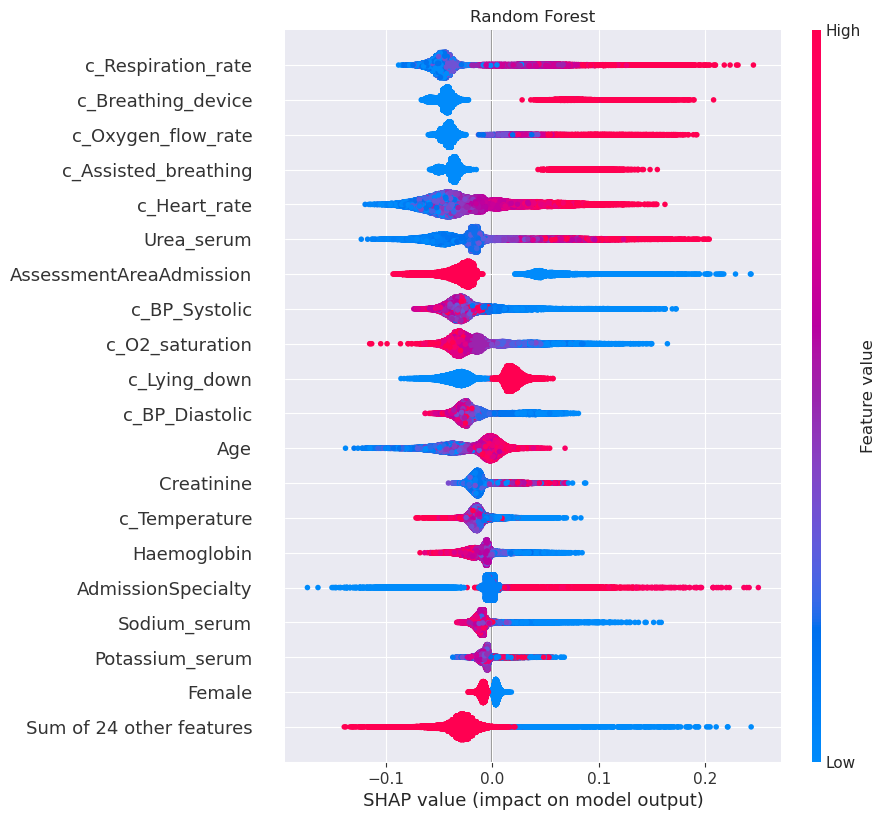

In [27]:
explainer = shap.TreeExplainer(model["RF"])
shap_values = explainer(X_test)
Notebook.EXPLAINERS[modelkey] = (explainer, shap_values)

fig = shap.plots.beeswarm(
    shap_values[:, :, 1], max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("Random Forest")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_swarm_random_forest.png", bbox_inches="tight"
    )


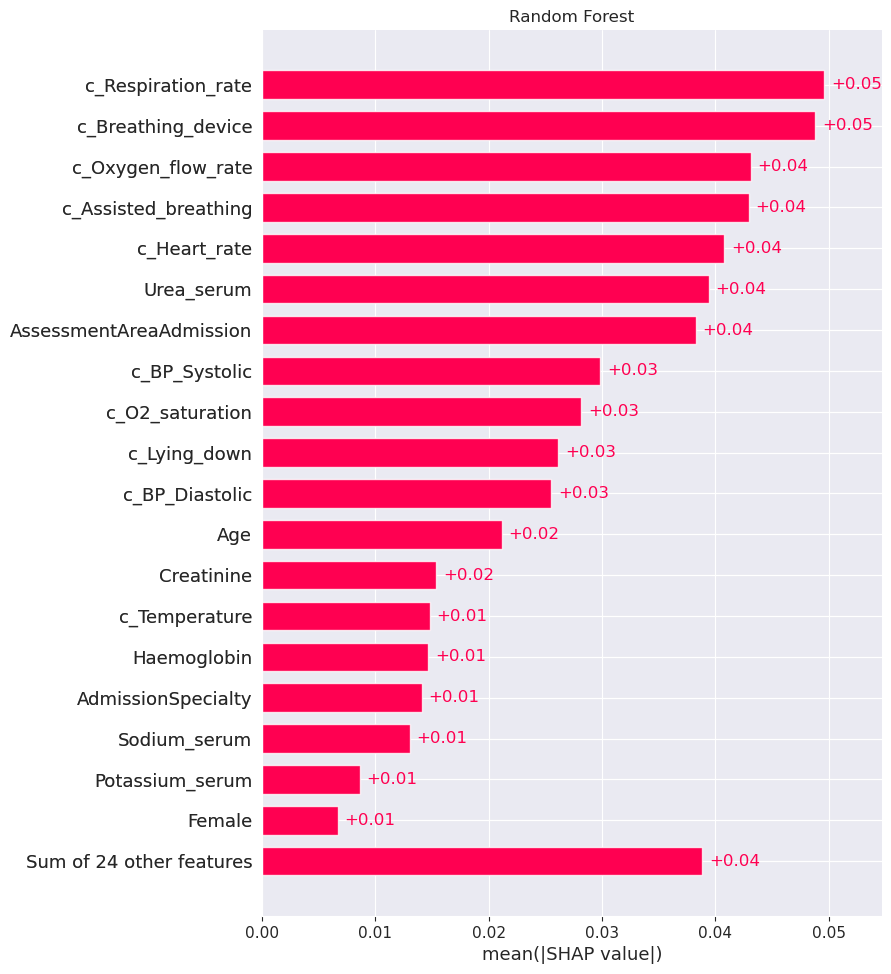

In [28]:
fig = shap.plots.bar(
    shap_values[:, :, 1], max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("Random Forest")

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/shap_bar_random_forest.png", bbox_inches="tight")


### XGBoost

In [29]:
xgboost_params = {
    "XGB__verbosity": 0,
    "XGB__n_jobs": 1,
    "XGB__missing": -1,
    "XGB__objective": "binary:logistic",
    "XGB__enable_categorical": True,
    "XGB__tree_method": "hist",
    "XGB__missing": -1,
    "XGB__booster": "gbtree",
    "XGB__lambda": 7e-2,
    "XGB__alpha": 7e-05,
    "XGB__subsample": 0.42,
    "XGB__colsample_bytree": 0.87,
    "XGB__scale_pos_weight": 14,
    "XGB__max_depth": 7,
    "XGB__min_child_weight": 10,
    "XGB__eta": 0.034,
    "XGB__gamma": 4e-08,
    "XGB__grow_policy": "lossguide",
    "IMB__sampling_strategy": 0.1,
}


if Notebook.RUN_HYPERPARAMETERS:
    xgboost_params.update(
        tune_xgboost(
            X_train_lgbm,
            y_train_lgbm,
            timeout=Notebook.HYPERPARAMETER_TIMEOUT,
            n_jobs=Notebook.HYPERPARAMETER_NJOBS,
        )
    )



BEST PARAMETERS
{'XGB__tree_method': 'approx', 'XGB__lambda': 1.2822693113536126e-08, 'XGB__alpha': 1.8600845799898402e-08, 'XGB__subsample': 0.7765219720355865, 'XGB__colsample_bytree': 0.6591189178780535, 'XGB__scale_pos_weight': 16, 'IMB__sampling_strategy': 0.4666372101920643, 'XGB__max_depth': 5, 'XGB__min_child_weight': 7, 'XGB__eta': 0.07394260231032992, 'XGB__gamma': 0.007486573146292602, 'XGB__grow_policy': 'depthwise'}


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.341071   0.102245  0.972346  0.185033  0.359863  0.853708   

            AUC_CI  
Model  0.845-0.862

array([[ 8511, 20994],
       [   68,  2391]])

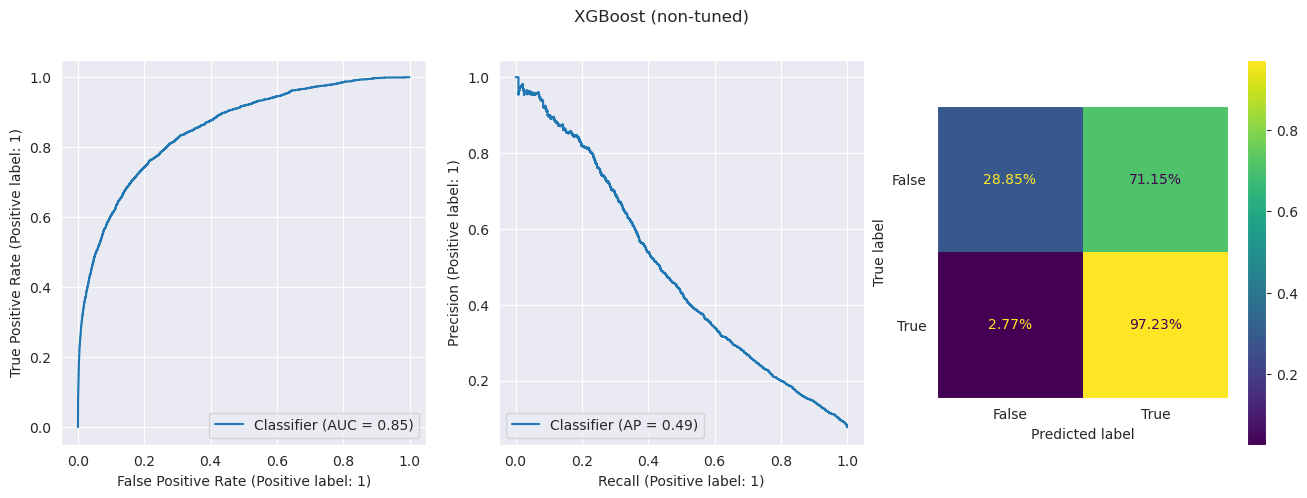

In [30]:
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

modelkey = "XGBoost"
model = (
    ImbPipeline(steps=[("IMB", RandomUnderSampler()), ("XGB", XGBClassifier()),])
    .set_params(**xgboost_params)
    .fit(X_train_lgbm, y_train_lgbm)
)

Notebook.MODELS[modelkey] = model

Notebook.EVAL_RESULTS[modelkey] = evaluate(
    model,
    X_test_lgbm,
    y_test_lgbm,
    "XGBoost (non-tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_xgboost.png" if Notebook.SAVE_IMAGES else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.122294   0.080531  0.999187  0.149049  0.304491  0.853708   

            AUC_CI  
Model  0.845-0.862

array([[ 1452, 28053],
       [    2,  2457]])

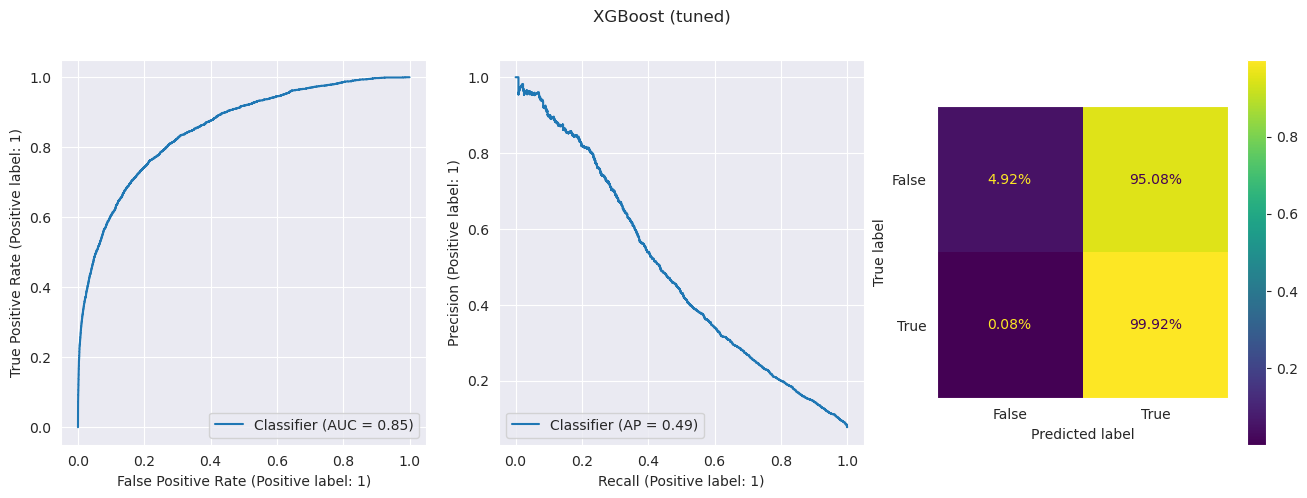

In [31]:
threshold = get_threshold(y_train_lgbm, model.predict_proba(X_train_lgbm)[:, 1],)

# Create predictions on the test set, using this new threshold
y_pred_proba = model.predict_proba(X_test_lgbm)[:, 1]
y_pred = np.where(y_pred_proba > 1 - threshold, 1, 0)

# Produce scores
Notebook.TUNED_RESULTS[modelkey] = evaluate_from_pred(
    y_test_lgbm,
    y_pred,
    y_pred_proba,
    plot_title="XGBoost (tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_thresholded_xgboost.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


Mortality


Accuracy  Precision  Recall  F1 Score  F2 Score       AUC       AUC_CI
Model  0.097109   0.054081     1.0  0.102612  0.222312  0.849672  0.841-0.858

array([[ 1454, 28860],
       [    0,  1650]])

Critical Care


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.077306   0.033399  0.998041  0.064635   0.14728  0.844212   

            AUC_CI  
Model  0.830-0.858

array([[ 1452, 29491],
       [    2,  1019]])

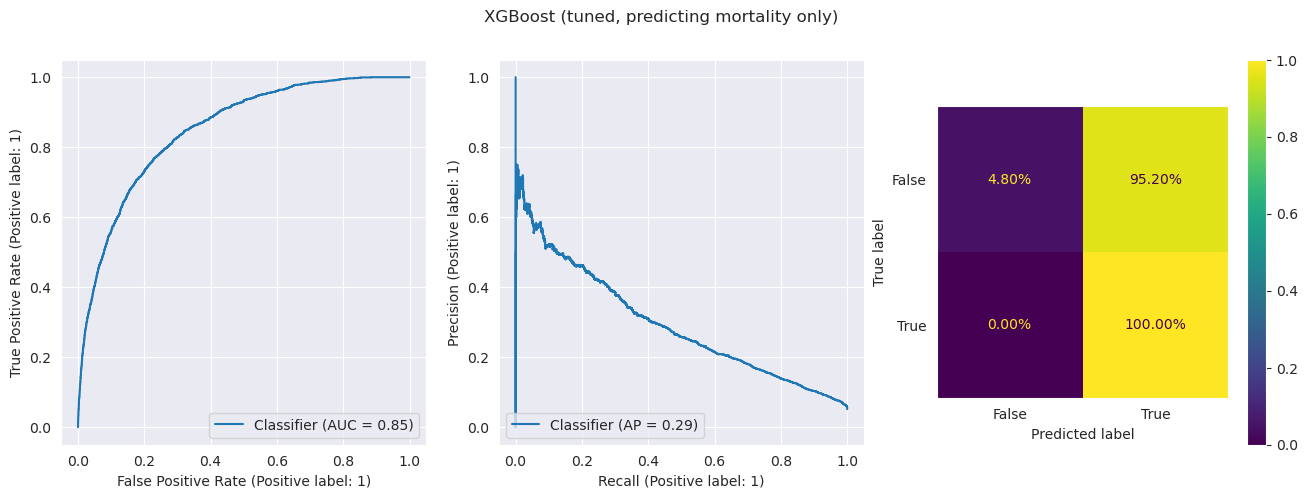

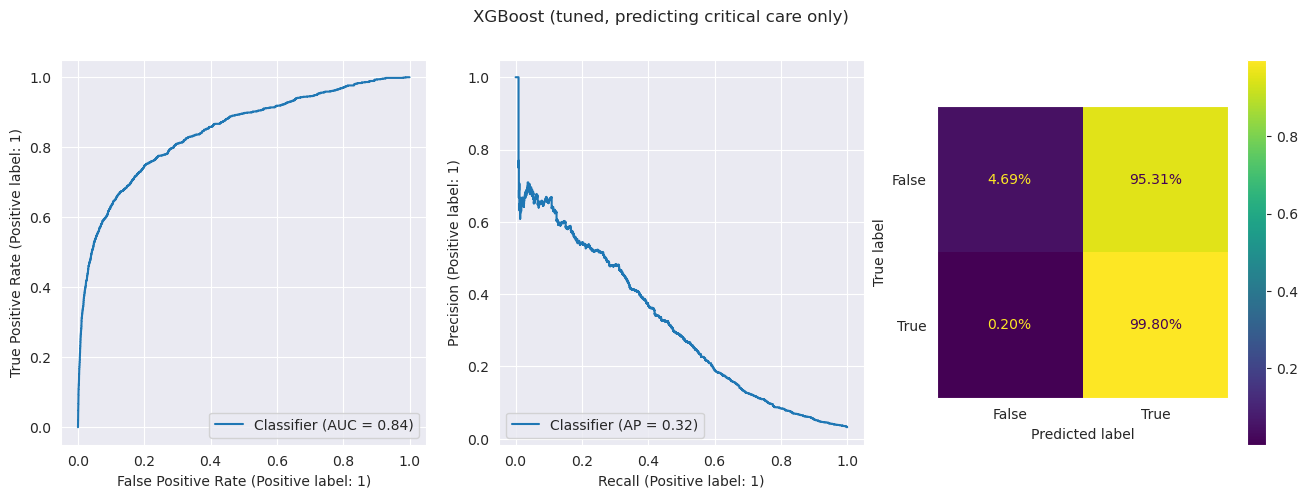

In [32]:
print("Mortality")
Notebook.MORTALITY_RESULTS[modelkey] = evaluate_from_pred(
    y_test_mortality,
    y_pred,
    y_pred_proba,
    plot_title="XGBoost (tuned, predicting mortality only)",
    save=f"{Notebook.IMAGE_DIR}/eval_mortality_thresholded_xgboost.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)

print("Critical Care")
Notebook.CRITICALCARE_RESULTS[modelkey] = evaluate_from_pred(
    y_test_criticalcare,
    y_pred,
    y_pred_proba,
    plot_title="XGBoost (tuned, predicting critical care only)",
    save=f"{Notebook.IMAGE_DIR}/eval_criticalcare_thresholded_xgboost.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


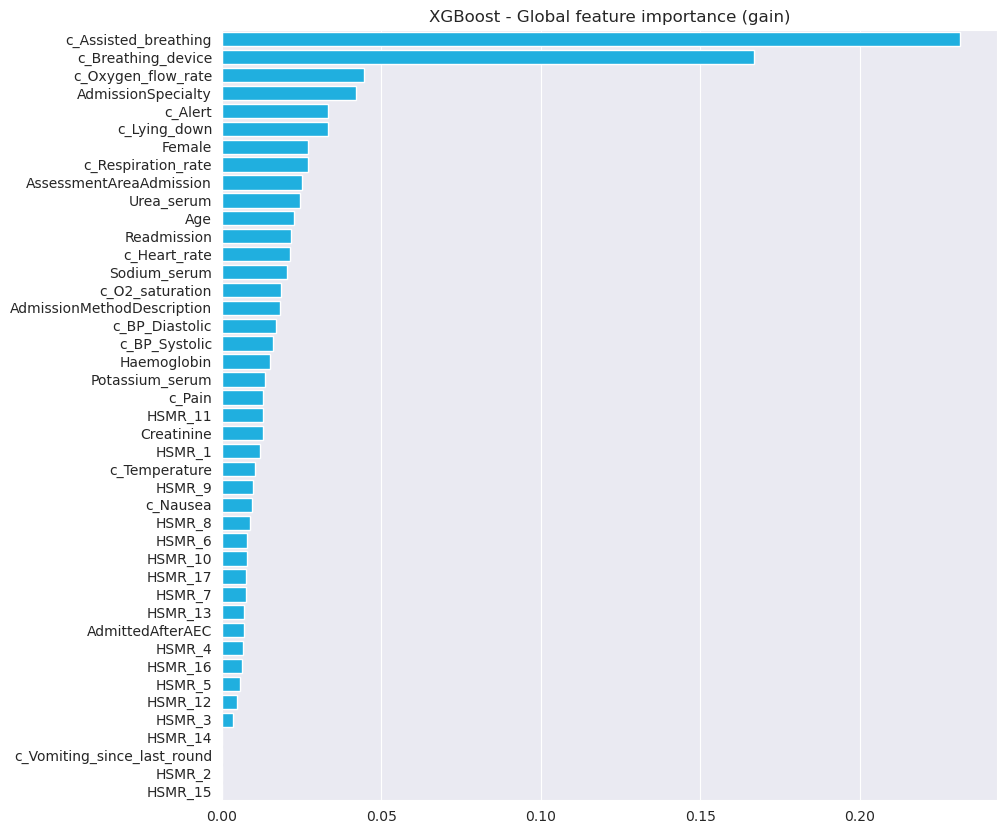

In [33]:
sorted_idx = model["XGB"].feature_importances_.argsort()[::-1]
fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.barplot(
    x=model["XGB"].feature_importances_[sorted_idx],
    y=X_train.columns[sorted_idx],
    color="deepskyblue",
    ax=ax
)
ax.set_title("XGBoost - Global feature importance (gain)")

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/global_weights_xgboost.png", bbox_inches="tight")



ntree_limit is deprecated, use `iteration_range` or model slicing instead.


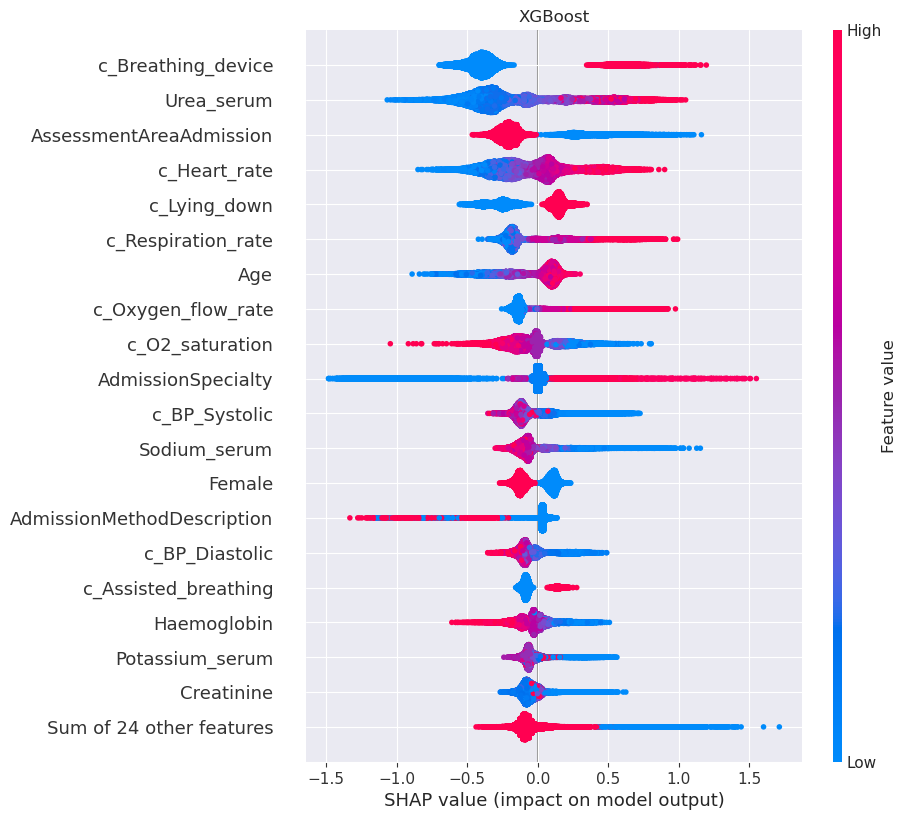

In [34]:
explainer = shap.TreeExplainer(model["XGB"])
shap_values = explainer(X_test)
Notebook.EXPLAINERS[modelkey] = (explainer, shap_values)

fig = shap.plots.beeswarm(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("XGBoost")

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/shap_swarm_xgboost.png", bbox_inches="tight")


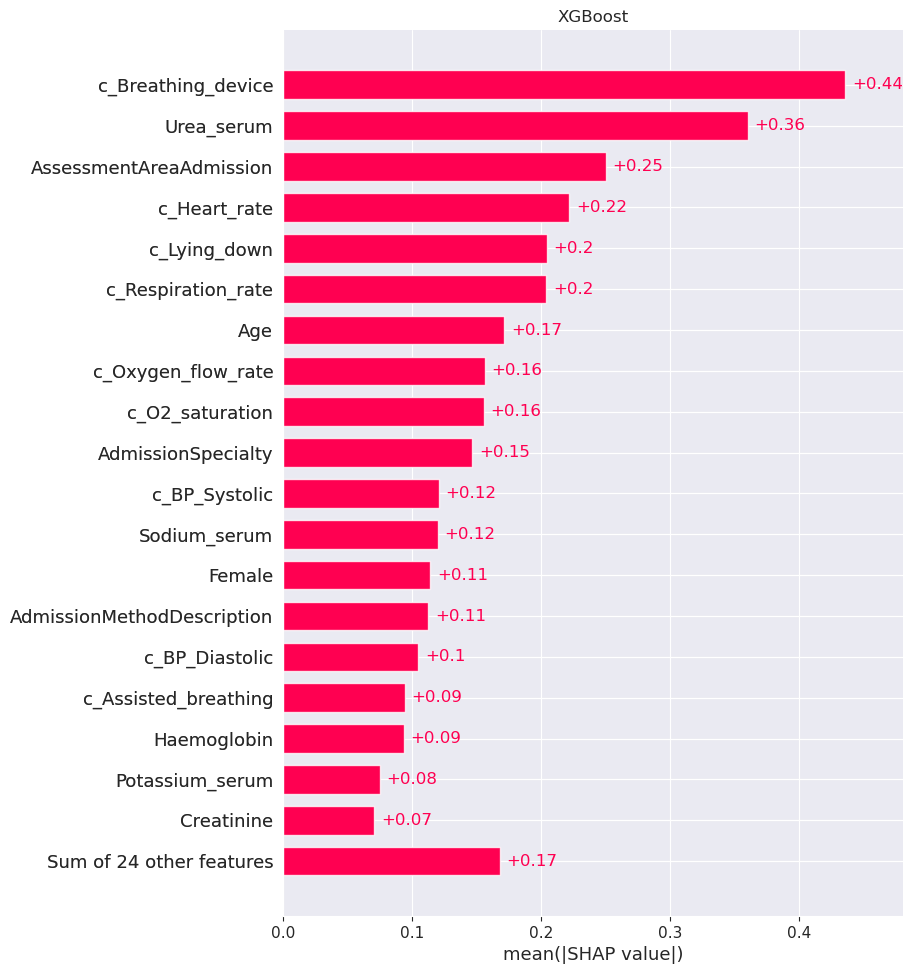

In [35]:
fig = shap.plots.bar(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("XGBoost")

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/shap_bar_xgboost.png", bbox_inches="tight")


### LightGBM

In [1]:
lgbm_params = {
    "LGBM__objective": "binary",
    "LGBM__metrics": ["l2", "auc"],
    "LGBM__boosting_type": "gbdt",
    "LGBM__is_unbalance": True,
    "LGBM__n_jobs": 1,
    "LGBM__feature_pre_filter": False,
    "LGBM__lambda_l1": 0.15,
    "LGBM__lambda_l2": 3.2,
    "LGBM__num_leaves": 225,
    "LGBM__feature_fraction": 0.8,
    "LGBM__bagging_fraction": 0.8,
    "LGBM__bagging_freq": 7,
    "LGBM__min_child_samples": 45,
    "IMB__sampling_strategy": 0.1,
}

if Notebook.RUN_HYPERPARAMETERS:
    lgbm_params.update(
        tune_lgbm(
            X_train_lgbm,
            y_train_lgbm,
            categorical_cols_idx,
            timeout=Notebook.HYPERPARAMETER_TIMEOUT,
            n_jobs=Notebook.HYPERPARAMETER_NJOBS,
        )
    )


BEST PARAMETERS
{'LGBM__lambda_l1': 0.5607444804859133, 'LGBM__lambda_l2': 1.1268476829899576e-07, 'LGBM__num_leaves': 12, 'LGBM__feature_fraction': 0.8542965875954117, 'LGBM__bagging_fraction': 0.9014520294150297, 'LGBM__bagging_freq': 5, 'LGBM__min_child_samples': 29, 'IMB__sampling_strategy': 0.11643611383783078}


[LightGBM] [Warning] feature_fraction is set=0.8542965875954117, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8542965875954117
[LightGBM] [Warning] lambda_l1 is set=0.5607444804859133, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5607444804859133
[LightGBM] [Warning] bagging_fraction is set=0.9014520294150297, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9014520294150297
[LightGBM] [Warning] lambda_l2 is set=1.1268476829899576e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1268476829899576e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


Accuracy  Precision    Recall  F1 Score  F2 Score      AUC       AUC_CI
Model  0.808973   0.249485  0.738512  0.372972  0.530529  0.85937  0.851-0.867

array([[24042,  5463],
       [  643,  1816]])

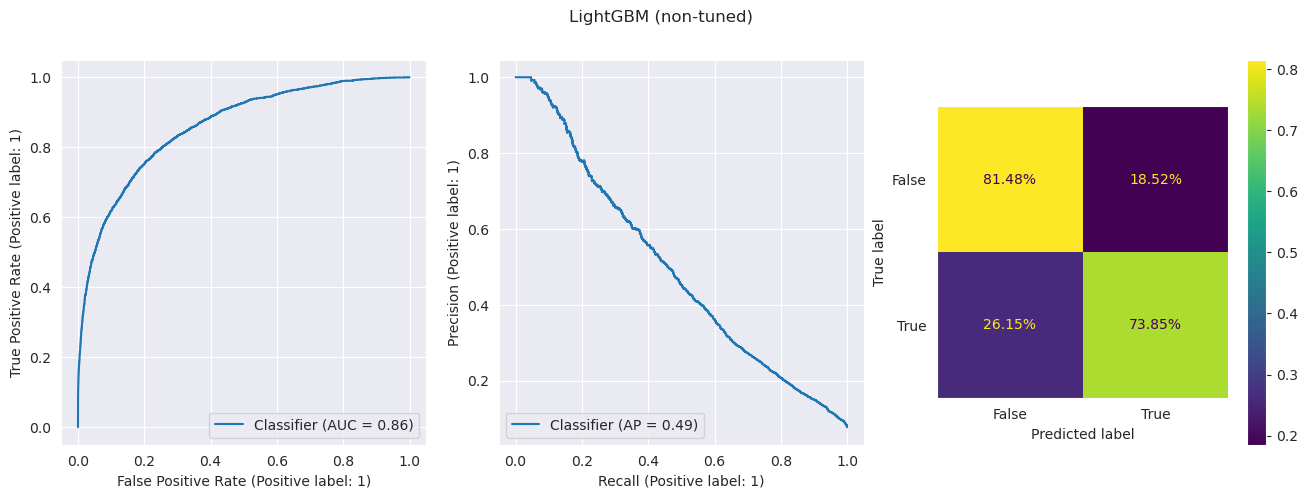

In [37]:
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

modelkey = "LightGBM"

model = (
    ImbPipeline(steps=[("IMB", RandomUnderSampler()), ("LGBM", LGBMClassifier()),])
    .set_params(**lgbm_params)
    .fit(
        X_train_lgbm,
        y_train_lgbm,
        LGBM__categorical_feature=categorical_cols_idx,
        LGBM__feature_name=list(X_train.columns),
    )
)

Notebook.MODELS[modelkey] = model

Notebook.EVAL_RESULTS[modelkey] = evaluate(
    model,
    X_test_lgbm,
    y_test_lgbm,
    plot_title="LightGBM (non-tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_lightgbm.png" if Notebook.SAVE_IMAGES else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


Accuracy  Precision    Recall  F1 Score  F2 Score      AUC       AUC_CI
Model  0.679139   0.174501  0.849939  0.289554  0.479072  0.85937  0.851-0.867

array([[19618,  9887],
       [  369,  2090]])

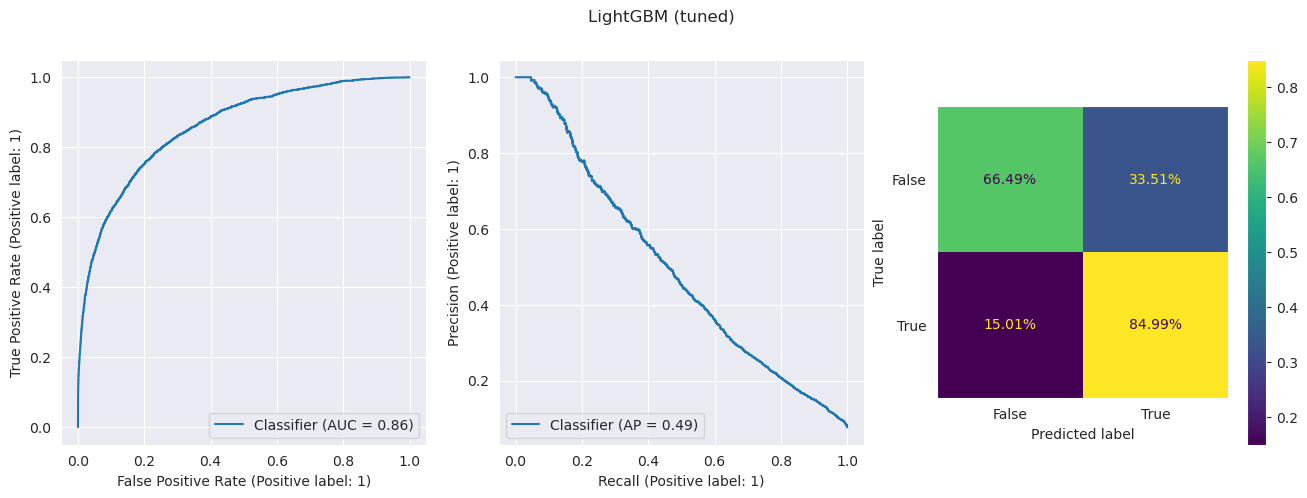

In [38]:
threshold = get_threshold(y_test_lgbm, model.predict_proba(X_test_lgbm)[:, 1],)

# Create predictions on the test set, using this new threshold
y_pred_proba = model.predict_proba(X_test_lgbm)[:, 1]
y_pred = np.where(y_pred_proba > threshold, 1, 0)

Notebook.TUNED_RESULTS[modelkey] = evaluate_from_pred(
    y_test_lgbm,
    y_pred,
    y_pred_proba,
    plot_title="LightGBM (tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_thresholded_lightgbm.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


Mortality


Accuracy  Precision  Recall  F1 Score  F2 Score       AUC       AUC_CI
Model  0.662464   0.118477    0.86  0.208263  0.381924  0.850023  0.841-0.859

array([[19756, 10558],
       [  231,  1419]])

Critical Care


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.647791   0.072639  0.852106  0.133867  0.270842  0.857469   

            AUC_CI  
Model  0.844-0.871

array([[19836, 11107],
       [  151,   870]])

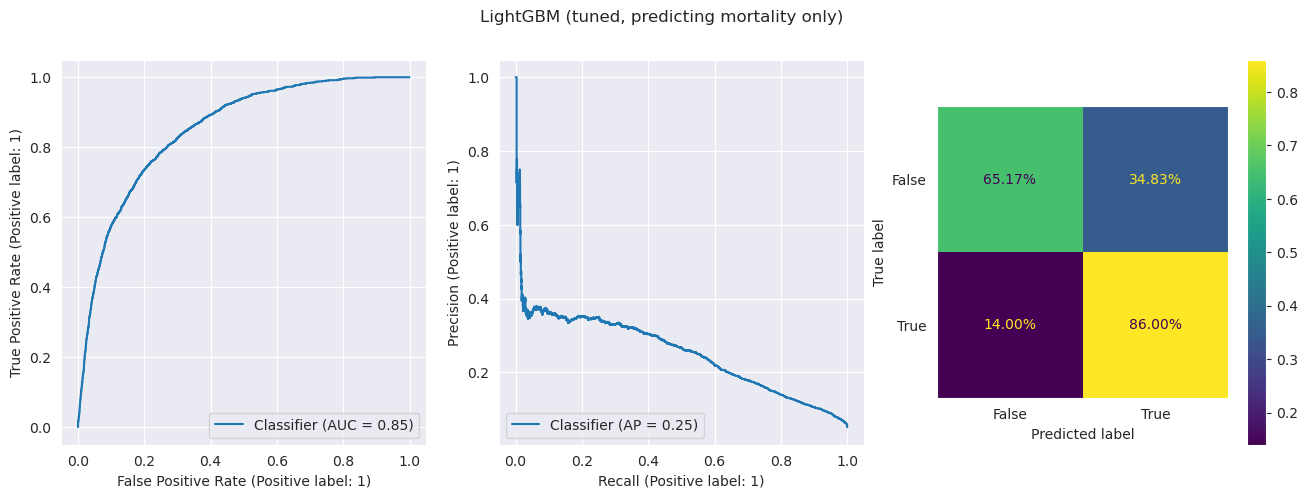

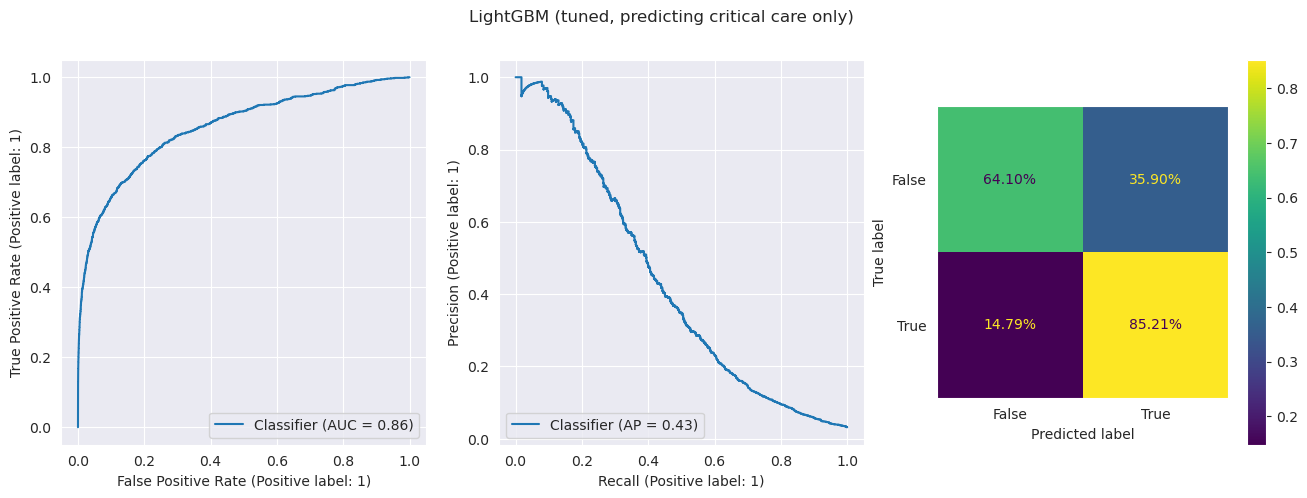

In [39]:
print("Mortality")
Notebook.MORTALITY_RESULTS[modelkey] = evaluate_from_pred(
    y_test_mortality,
    y_pred,
    y_pred_proba,
    plot_title="LightGBM (tuned, predicting mortality only)",
    save=f"{Notebook.IMAGE_DIR}/eval_mortality_thresholded_lightgbm.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)

print("Critical Care")
Notebook.CRITICALCARE_RESULTS[modelkey] = evaluate_from_pred(
    y_test_criticalcare,
    y_pred,
    y_pred_proba,
    plot_title="LightGBM (tuned, predicting critical care only)",
    save=f"{Notebook.IMAGE_DIR}/eval_criticalcare_thresholded_lightgbm.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


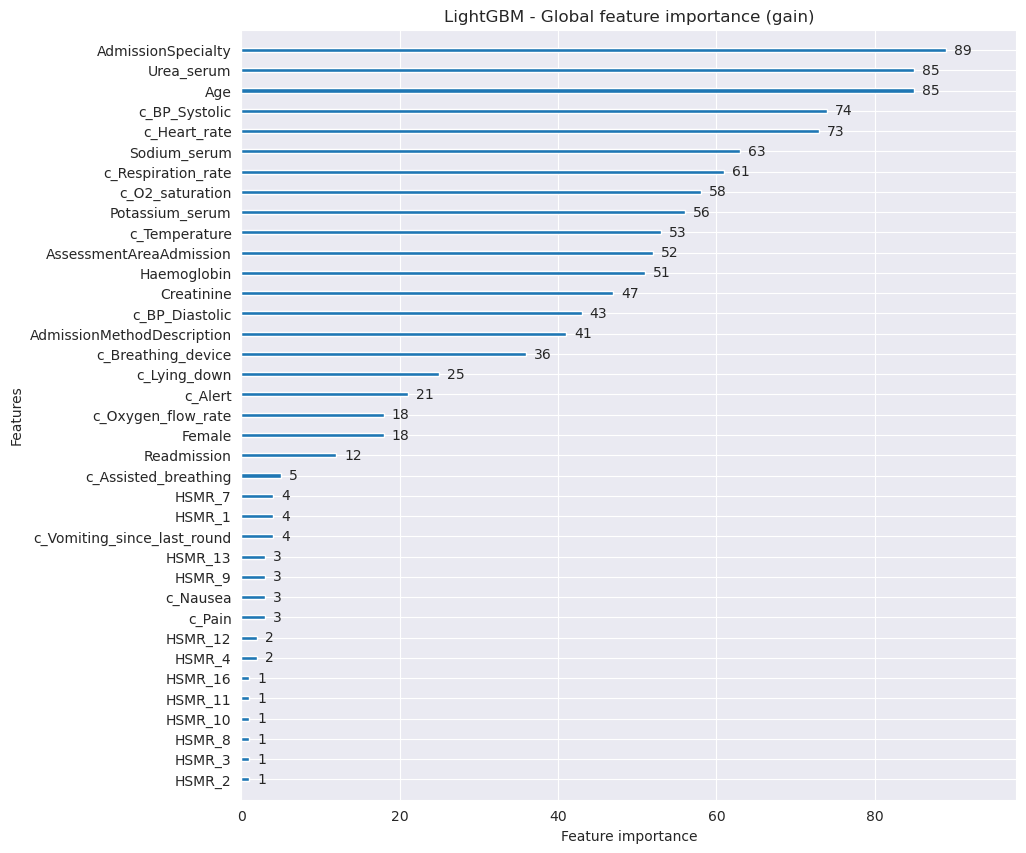

In [40]:
import lightgbm as lgb

fig = lgb.plot_importance(model["LGBM"], figsize=(10, 10))
fig.set_title("LightGBM - Global feature importance (gain)")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/global_weights_lightgbm.png", bbox_inches="tight"
    )


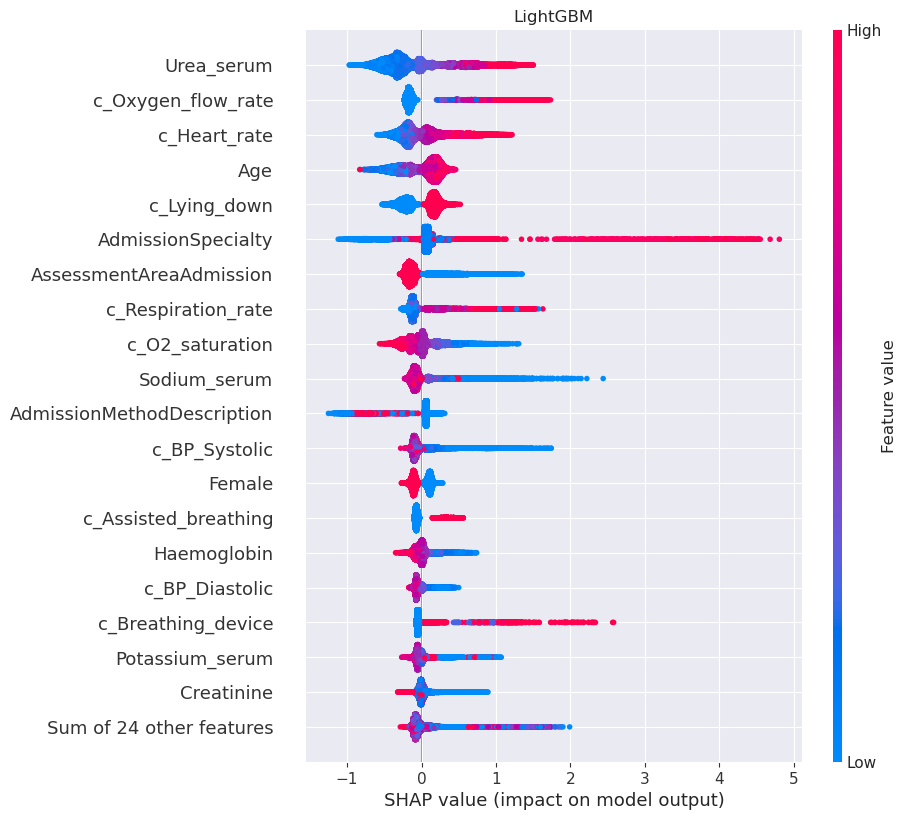

In [41]:
explainer = shap.TreeExplainer(model["LGBM"])
shap_values = explainer(X_test)
Notebook.EXPLAINERS[modelkey] = (explainer, shap_values)

fig = shap.plots.beeswarm(
    shap_values[:, :, 1], max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("LightGBM")
if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/shap_swarm_lightgbm.png", bbox_inches="tight")


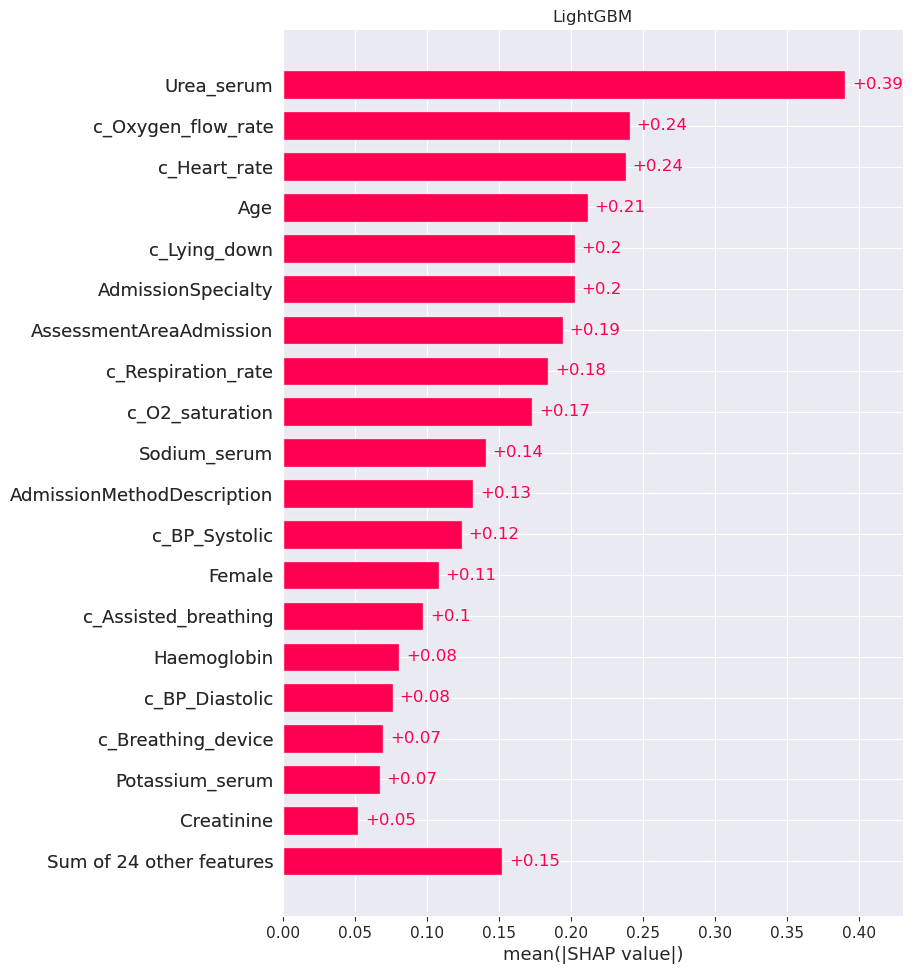

In [42]:
fig = shap.plots.bar(
    shap_values[:, :, 1], max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("LightGBM")

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/shap_bar_lightgbm.png", bbox_inches="tight")


### Isolation Forest

In [43]:
if_params = {
    "n_estimators": 140,
    "max_samples": 0.465,
    "contamination": 0.0213,
    "max_features": 0.69,
    "bootstrap": False,
}

if Notebook.RUN_HYPERPARAMETERS:
    if_params = tune_isolationforest(
        X_train_if,
        y_train_if,
        timeout=Notebook.HYPERPARAMETER_TIMEOUT,
        n_jobs=Notebook.HYPERPARAMETER_NJOBS,
    )



BEST PARAMETERS
{'n_estimators': 194, 'max_samples': 0.3419214302609085, 'contamination': 0.0641058647300069, 'max_features': 0.13803698958096935, 'bootstrap': False}


Accuracy  Precision   Recall  F1 Score  F2 Score       AUC       AUC_CI
Model  0.865536    0.27976  0.47499  0.352125  0.416815  0.768011  0.757-0.778

array([[26498,  3007],
       [ 1291,  1168]])

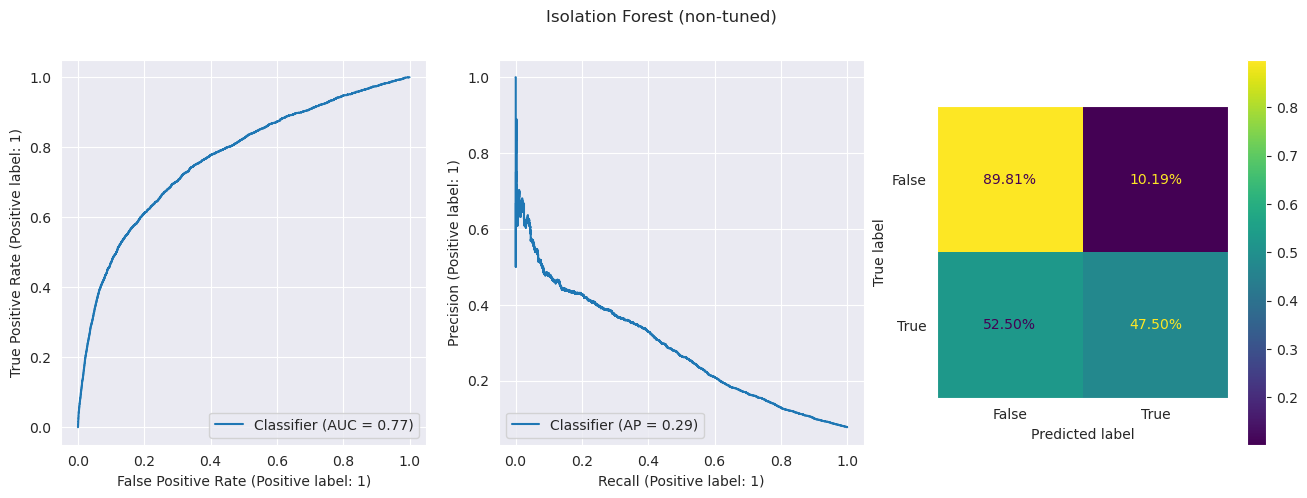

In [44]:
modelkey = "Isolation Forest"

model = IsolationForestWrapper(**if_params).fit(X_train_if[~y_train_if].to_numpy())
Notebook.MODELS[modelkey] = model

Notebook.EVAL_RESULTS[modelkey] = evaluate(
    model,
    X_test_if.to_numpy(),
    y_test_if,
    plot_title="Isolation Forest (non-tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_isolation_forest.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model   0.46884   0.112434  0.856446  0.198773  0.368607  0.768011   

            AUC_CI  
Model  0.757-0.778

array([[12880, 16625],
       [  353,  2106]])

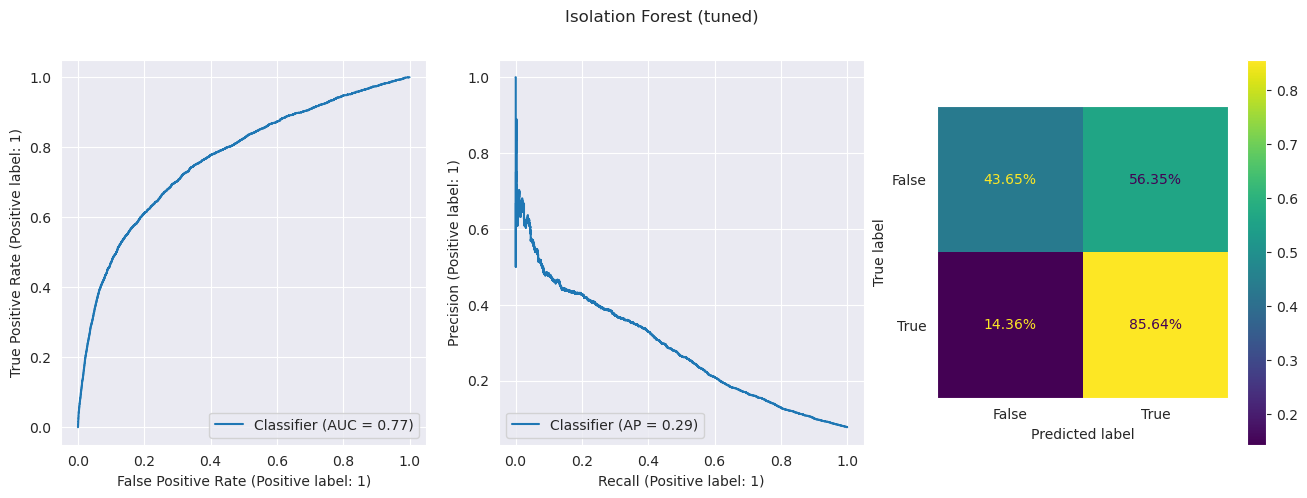

In [45]:
y_pred_proba_train = model.decision_function(X_train_if)
y_pred_proba_train -= y_pred_proba_train.min()

threshold = get_threshold(y_train_if, y_pred_proba_train,)

# Create predictions on the test set, using this new threshold
y_pred_proba = model.decision_function(X_test_if)
y_pred = np.where(y_pred_proba - y_pred_proba.min() > threshold, 1, 0)

Notebook.TUNED_RESULTS[modelkey] = evaluate_from_pred(
    y_test_if,
    y_pred,
    y_pred_proba,
    plot_title="Isolation Forest (tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_thresholded_isolation_forest.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


Mortality


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model   0.44816   0.073194  0.830909  0.134537  0.270617  0.731691   

            AUC_CI  
Model  0.718-0.745

array([[12954, 17360],
       [  279,  1371]])

Critical Care


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.440808   0.050131  0.919687  0.095079  0.205786  0.826682   

            AUC_CI  
Model  0.813-0.840

array([[13151, 17792],
       [   82,   939]])

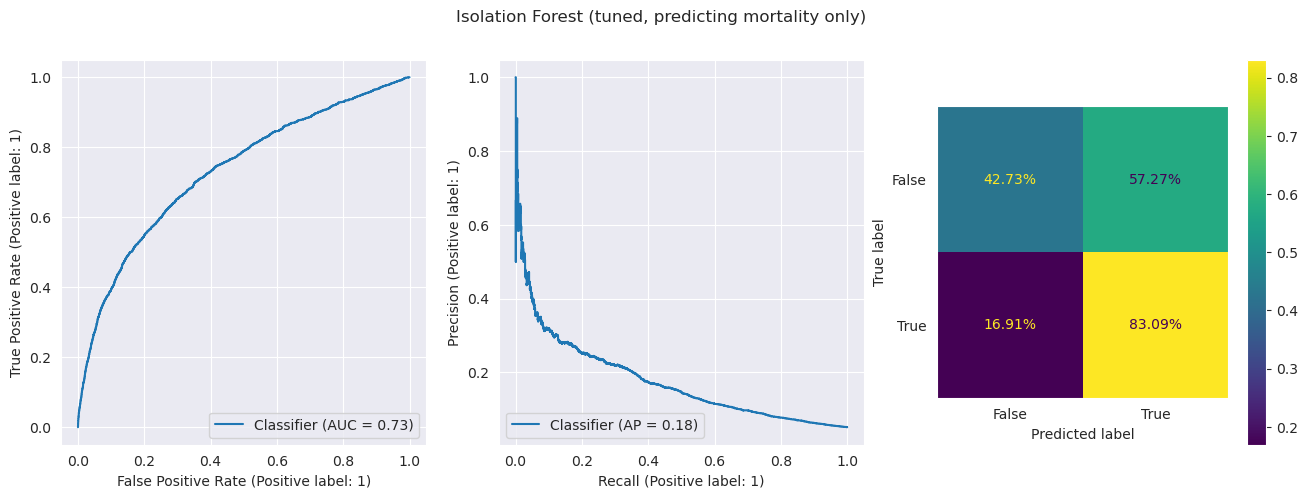

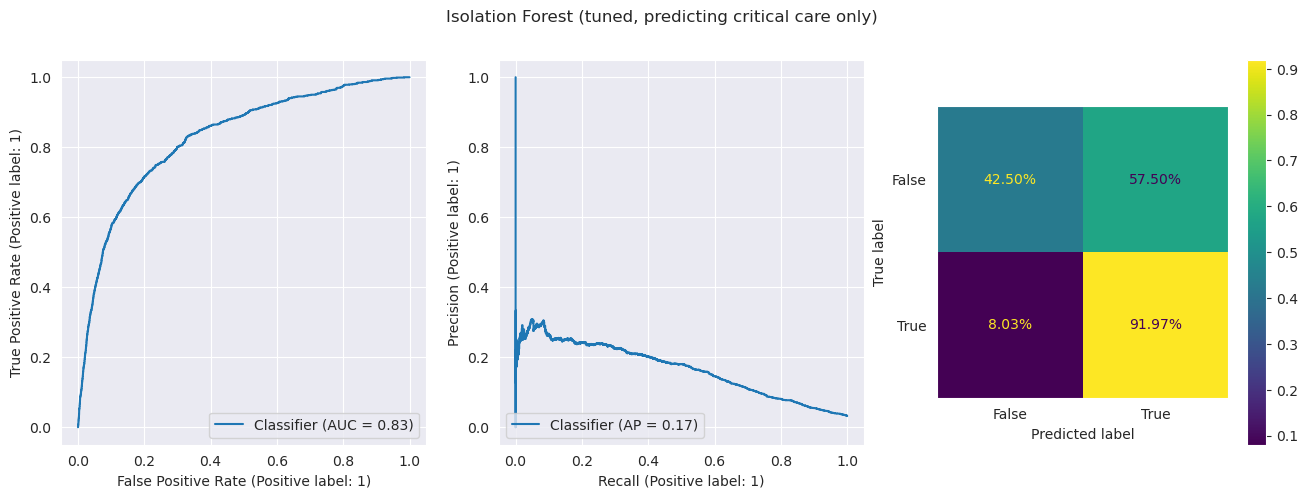

In [46]:
print("Mortality")
Notebook.MORTALITY_RESULTS[modelkey] = evaluate_from_pred(
    y_test_mortality,
    y_pred,
    y_pred_proba,
    plot_title="Isolation Forest (tuned, predicting mortality only)",
    save=f"{Notebook.IMAGE_DIR}/eval_mortality_thresholded_isolation_forest.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)

print("Critical Care")
Notebook.CRITICALCARE_RESULTS[modelkey] = evaluate_from_pred(
    y_test_criticalcare,
    y_pred,
    y_pred_proba,
    plot_title="Isolation Forest (tuned, predicting critical care only)",
    save=f"{Notebook.IMAGE_DIR}/eval_criticalcare_thresholded_isolation_forest.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


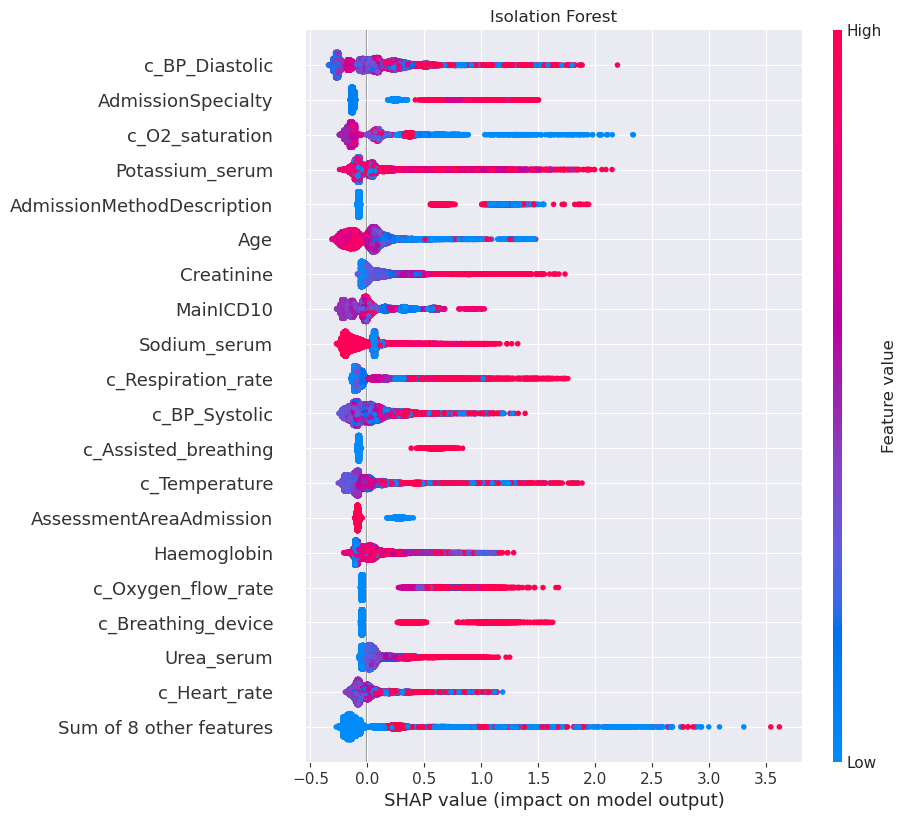

In [47]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test_if)
shap_values.values = -shap_values.values  # Fix for isolation forest's unique labelling
Notebook.EXPLAINERS[modelkey] = (explainer, shap_values)

fig = shap.plots.beeswarm(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("Isolation Forest")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_swarm_isolation_forest.png", bbox_inches="tight"
    )



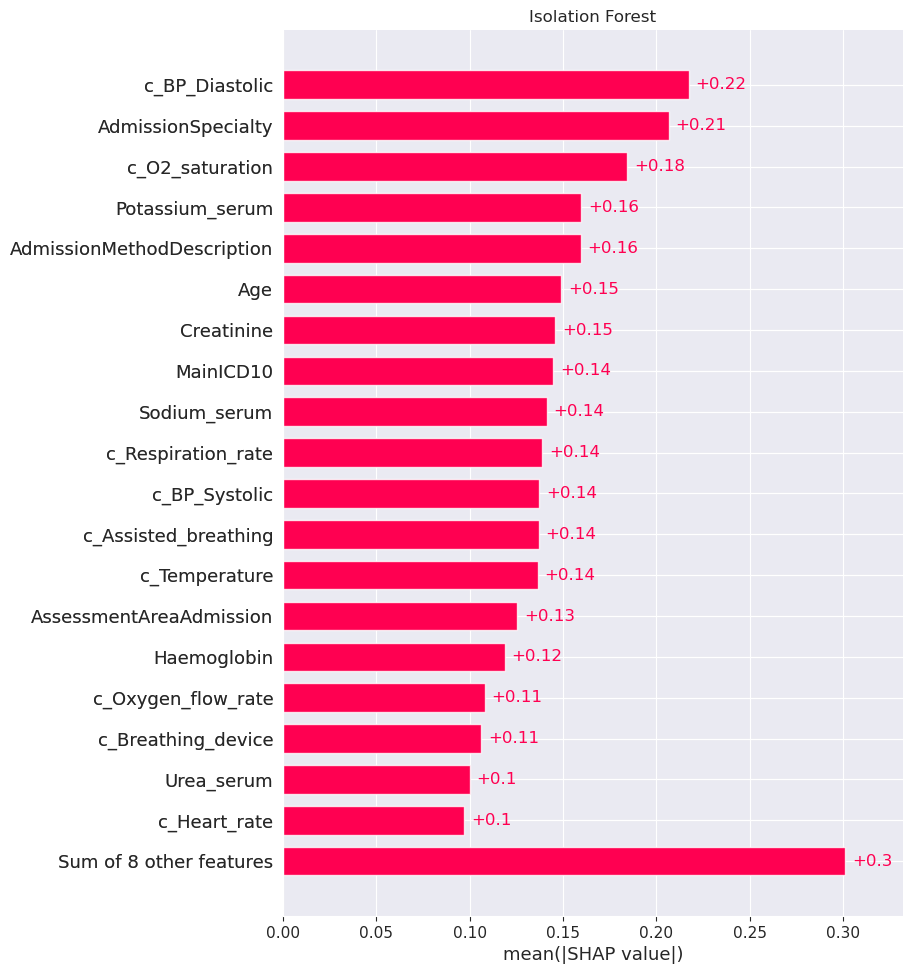

In [48]:
fig = shap.plots.bar(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("Isolation Forest")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_bar_isolation_forest.png", bbox_inches="tight"
    )



### TabNet

In [2]:
import torch
from pytorch_tabnet.tab_model import TabNetClassifier

tabnet_params = dict(
    cat_idxs=categorical_cols_idx,
    cat_dims=categorical_cols_dims,
    n_a=64,
    n_d=64,
    n_steps=3,
    gamma=1.0,
    lambda_sparse=9e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=0.02, weight_decay=1e-05),
    mask_type="sparsemax",
    n_shared=1,
    scheduler_params=dict(mode="min", patience=5, min_lr=1e-05, factor=0.5,),
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
    verbose=0,
    device_name="cuda" if torch.cuda.is_available() else "cpu",
)

if Notebook.RUN_HYPERPARAMETERS:
    returned_params, tabnet_patience, tabnet_scheduler_patience = tune_tabnet(
        X_train,
        y_train,
        categorical_cols_idx,
        categorical_cols_dims,
        timeout=Notebook.HYPERPARAMETER_TIMEOUT,
        n_jobs=Notebook.HYPERPARAMETER_NJOBS,
    )

    tabnet_params.update(returned_params)
    tabnet_params["scheduler_params"]["patience"] = tabnet_scheduler_patience



BEST PARAMETERS
{'n_steps': 3, 'gamma': 1.2, 'lambda_sparse': 3.587551946382179e-06, 'mask_type': 'sparsemax', 'n_shared': 2, 'n_a': 64, 'n_d': 64}



Early stopping occurred at epoch 28 with best_epoch = 9 and best_valid_auc = 0.83528
Best weights from best epoch are automatically used!


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.787167   0.224225  0.718178  0.341751  0.498532  0.831827   

            AUC_CI  
Model  0.823-0.841

array([[23395,  6110],
       [  693,  1766]])

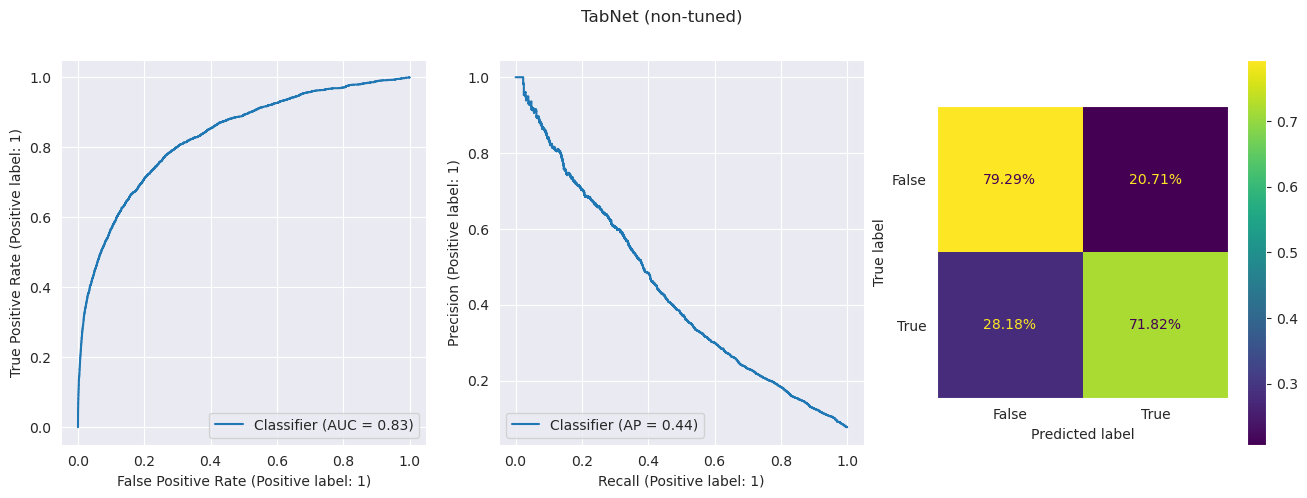

In [50]:
modelkey = "TabNet"
model = TabNetClassifier(**tabnet_params)
model.fit(
    X_train=X_train_tn,
    y_train=y_train_tn,
    eval_set=[(X_train_tn, y_train_tn), (X_valid_tn, y_valid_tn)],
    eval_name=["train", "valid"],
    eval_metric=["auc"],
    max_epochs=100,
    patience=tabnet_patience,
    # batch_size=512,
    # virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
)

Notebook.MODELS[modelkey] = model

Notebook.EVAL_RESULTS[modelkey] = evaluate(
    model,
    X_test.to_numpy(),
    y_test,
    "TabNet (non-tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_tabnet.png" if Notebook.SAVE_IMAGES else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.728789   0.191658  0.784872  0.308085  0.484778  0.831827   

            AUC_CI  
Model  0.823-0.841

array([[21365,  8140],
       [  529,  1930]])

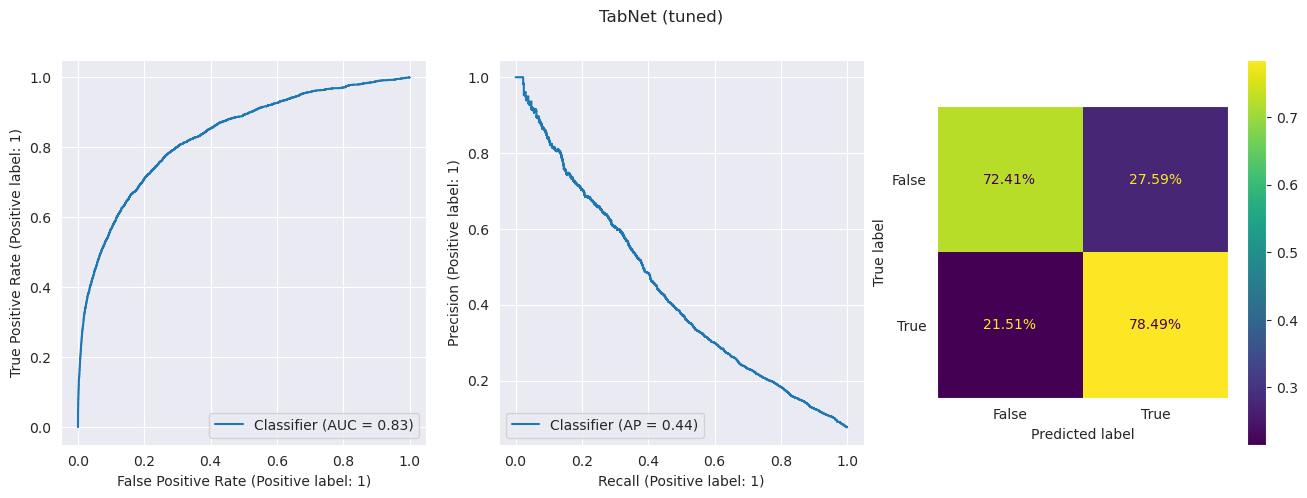

In [51]:
threshold = get_threshold(
    y_test, model.predict_proba(X_test.to_numpy())[:, 1], target=0.785
)

# Create predictions on the test set, using this new threshold
y_pred_proba = model.predict_proba(X_test.to_numpy())[:, 1]
y_pred = np.where(y_pred_proba > threshold, 1, 0)

Notebook.TUNED_RESULTS[modelkey] = evaluate_from_pred(
    y_test,
    y_pred,
    y_pred_proba,
    plot_title="TabNet (tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_thresholded_tabnet.png"
    if Notebook.SAVE_IMAGES
    else None,
)


Mortality


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model   0.71543   0.130288  0.795152  0.223891  0.393521  0.828335   

            AUC_CI  
Model  0.818-0.838

array([[21556,  8758],
       [  338,  1312]])

Critical Care


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.703385    0.07994  0.788443  0.145163  0.284372  0.824414   

            AUC_CI  
Model  0.809-0.839

array([[21678,  9265],
       [  216,   805]])

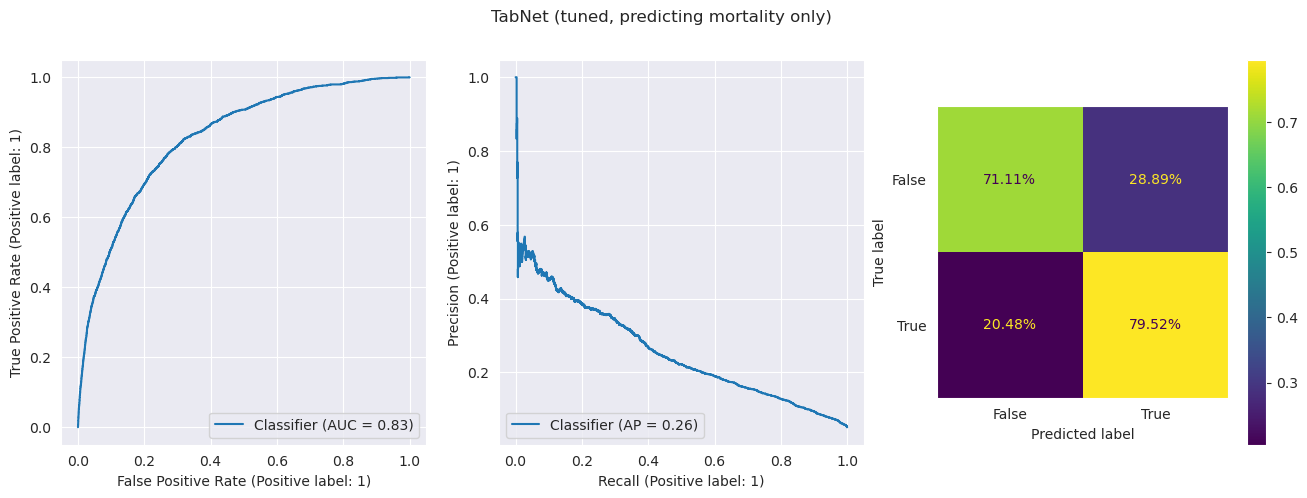

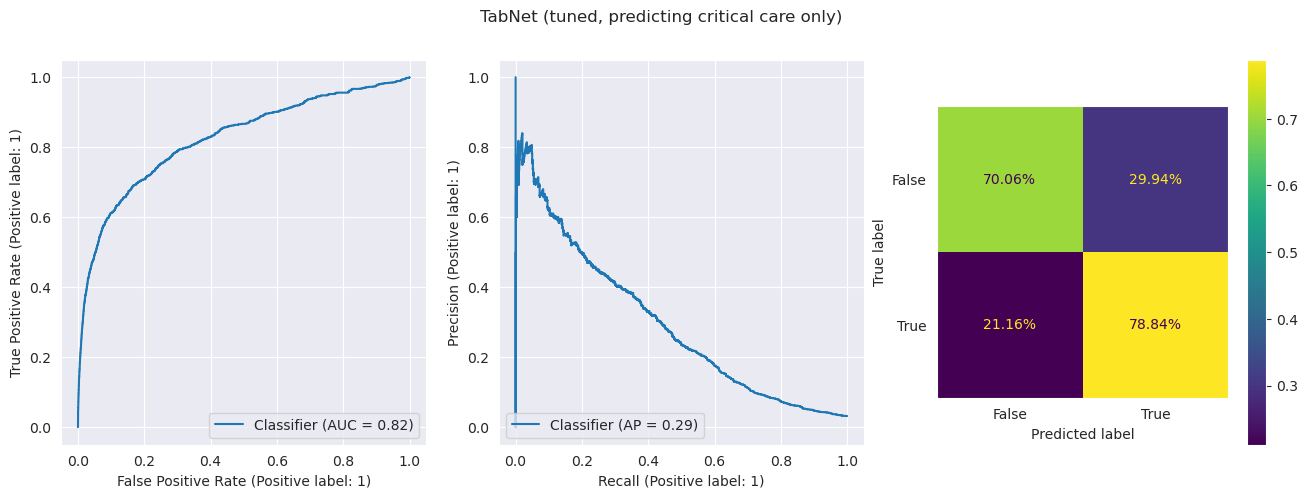

In [52]:
print("Mortality")
Notebook.MORTALITY_RESULTS[modelkey] = evaluate_from_pred(
    y_test_mortality,
    y_pred,
    y_pred_proba,
    plot_title="TabNet (tuned, predicting mortality only)",
    save=f"{Notebook.IMAGE_DIR}/eval_mortality_thresholded_tabnet.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)

print("Critical Care")
Notebook.CRITICALCARE_RESULTS[modelkey] = evaluate_from_pred(
    y_test_criticalcare,
    y_pred,
    y_pred_proba,
    plot_title="TabNet (tuned, predicting critical care only)",
    save=f"{Notebook.IMAGE_DIR}/eval_criticalcare_thresholded_tabnet.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


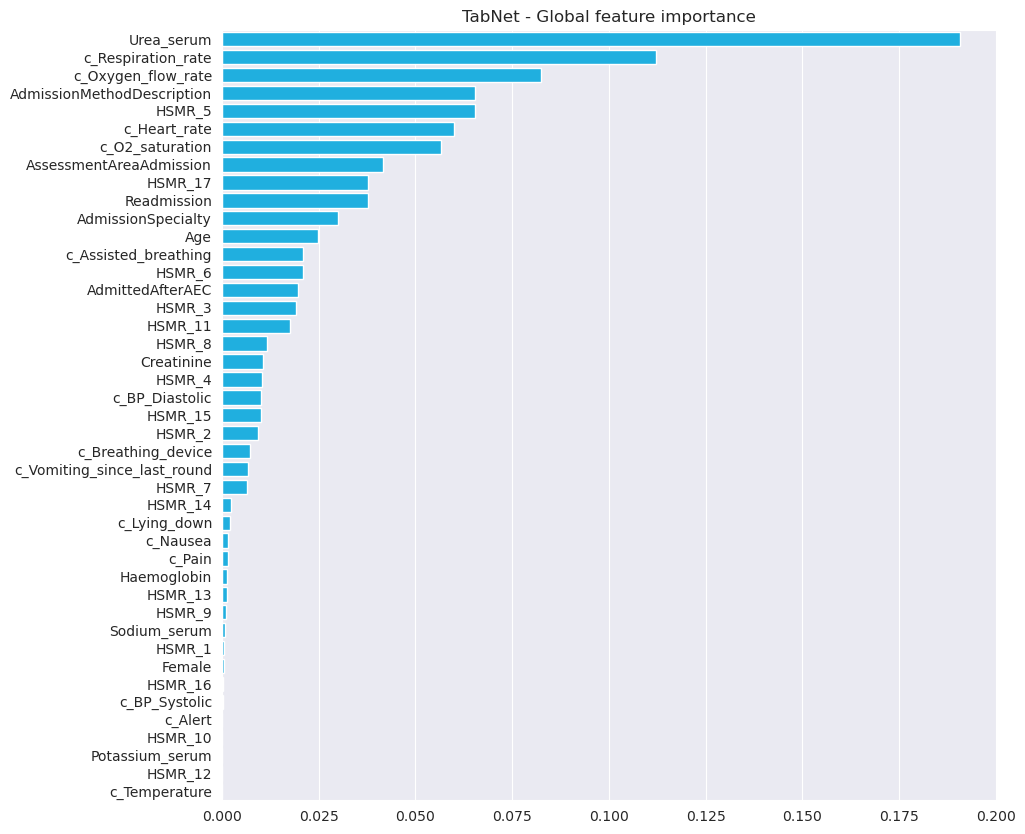

In [53]:
sorted_idx = model.feature_importances_.argsort()[::-1]
fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.barplot(
    x=model.feature_importances_[sorted_idx],
    y=X_train.columns[sorted_idx],
    color="deepskyblue",
    ax=ax
)
ax.set_title("TabNet - Global feature importance")

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/global_weights_tabnet.png", bbox_inches="tight")



Using 4419 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/15000 [00:00<?, ?it/s]

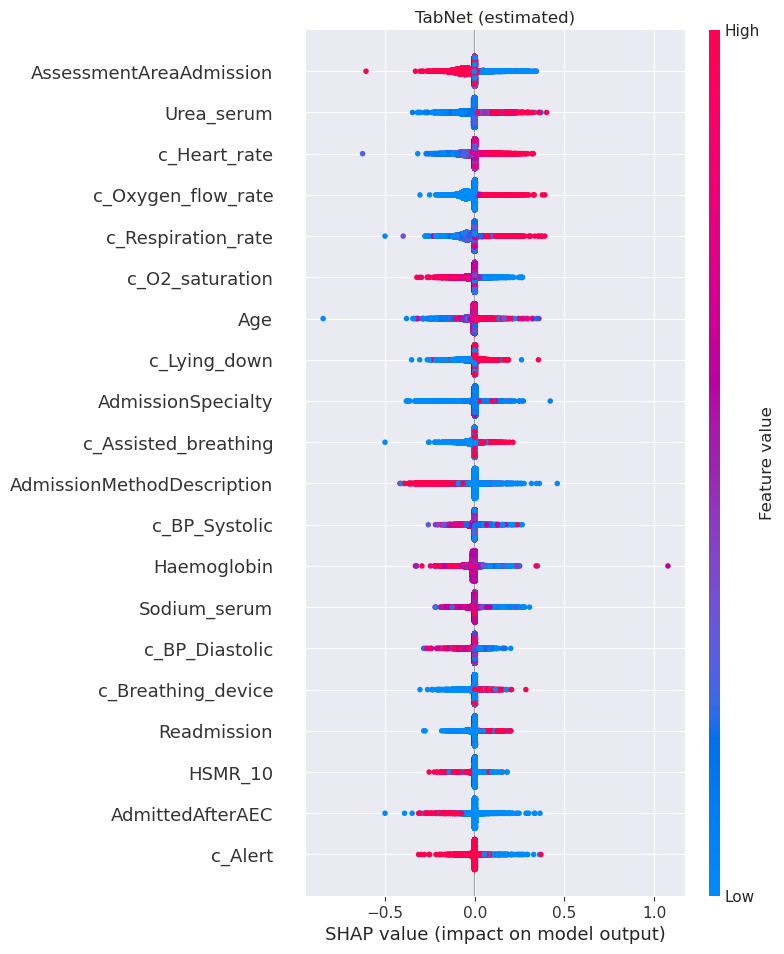

In [54]:
X_test_tn_shap = shap.sample(X_test.to_numpy(), 15000)
explainer = shap.KernelExplainer(model.predict_proba, np.concatenate((shap.sample(X_train_tn[~y_train_tn], 1000), X_train_tn[y_train_tn])))
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    shap_values = explainer.shap_values(X_test_tn_shap, nsamples=50)

Notebook.EXPLAINERS[modelkey] = (explainer, shap_values)

shap.summary_plot(
    shap_values[1],
    X_test_tn_shap,
    feature_names=X_test.columns,
    show=False,
    max_display=Notebook.SHAP_PLOTS_MAXDISPLAY,
    plot_type="dot",
)
plt.title("TabNet (estimated)")

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/shap_swarm_tabnet.png", bbox_inches="tight")


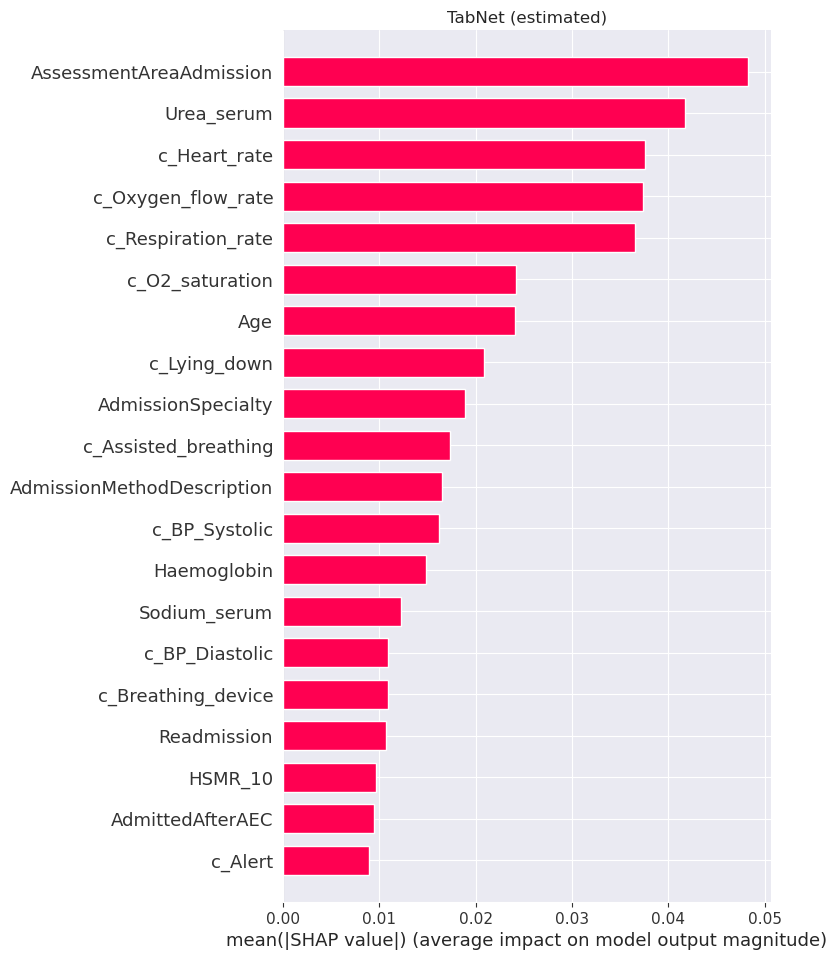

In [55]:
shap.summary_plot(
    shap_values[1],
    X_test_tn_shap,
    feature_names=X_test.columns,
    show=False,
    max_display=Notebook.SHAP_PLOTS_MAXDISPLAY,
    plot_type="bar",
    color=shap.plots.colors.red_rgb,
)
plt.title("TabNet (estimated)")

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/shap_bar_tabnet.png", bbox_inches="tight")


In [56]:
if Notebook.SAVE_MODELS:
    with open(f"{Notebook.MODEL_DIR}/models.bin", "wb") as file:
        pickle.dump(Notebook.MODELS, file)

    with open(f"{Notebook.MODEL_DIR}/explainers.bin", "wb") as file:
        pickle.dump(Notebook.EXPLAINERS, file)


## Comparisons

### Scores

#### Pre-tuning scores

In [57]:
pd.concat(
    [results[0].assign(Model=key) for key, results in Notebook.EVAL_RESULTS.items()]
).set_index("Model")



Accuracy  Precision    Recall  F1 Score  \
Model                                                                      
Baseline (NEWS)                  0.927606   0.623090  0.149248  0.240814   
Logistic Regression (NEWS only)  0.835033   0.249377  0.569337  0.346835   
Logistic Regression              0.798961   0.233078  0.704351  0.350253   
Random Forest                    0.915843   0.454039  0.464010  0.458970   
XGBoost                          0.341071   0.102245  0.972346  0.185033   
LightGBM                         0.808973   0.249485  0.738512  0.372972   
Isolation Forest                 0.865536   0.279760  0.474990  0.352125   
TabNet                           0.787167   0.224225  0.718178  0.341751   

                                 F2 Score       AUC       AUC_CI  
Model                                                             
Baseline (NEWS)                  0.176019  0.765840  0.755-0.777  
Logistic Regression (NEWS only)  0.453074  0.774184  0.764-0.785  
Logistic Regression              0.501535  0.831468  0.822-0.840  
Random Forest                    0.461981  0.851465  0.843-0.860  
XGBoost                          0.359863  0.853708  0.845-0.862  
LightGBM                         0.530529  0.859370  0.851-0.867  
Isolation Forest                 0.416815  0.768011  0.757-0.778  
TabNet                           0.498532  0.831827  0.823-0.841

#### Post-tuning scores

In [58]:
pd.concat(
    [results[0].assign(Model=key) for key, results in Notebook.TUNED_RESULTS.items()]
).set_index("Model")



Accuracy  Precision    Recall  F1 Score  \
Model                                                                      
Logistic Regression (NEWS only)  0.530440   0.122715  0.830012  0.213818   
Logistic Regression              0.651326   0.160119  0.832046  0.268557   
Random Forest                    0.919441   0.474628  0.441236  0.457323   
XGBoost                          0.122294   0.080531  0.999187  0.149049   
LightGBM                         0.679139   0.174501  0.849939  0.289554   
Isolation Forest                 0.468840   0.112434  0.856446  0.198773   
TabNet                           0.728789   0.191658  0.784872  0.308085   

                                 F2 Score       AUC       AUC_CI  
Model                                                             
Logistic Regression (NEWS only)  0.385560  0.774184  0.764-0.785  
Logistic Regression              0.452375  0.831468  0.822-0.840  
Random Forest                    0.447533  0.851465  0.843-0.860  
XGBoost                          0.304491  0.853708  0.845-0.862  
LightGBM                         0.479072  0.859370  0.851-0.867  
Isolation Forest                 0.368607  0.768011  0.757-0.778  
TabNet                           0.484778  0.831827  0.823-0.841

### ROC

In [59]:
roc_dict, pr_dict = (
    {key: val[1] for key, val in Notebook.EVAL_RESULTS.items()},
    {key: val[2] for key, val in Notebook.EVAL_RESULTS.items()},
)



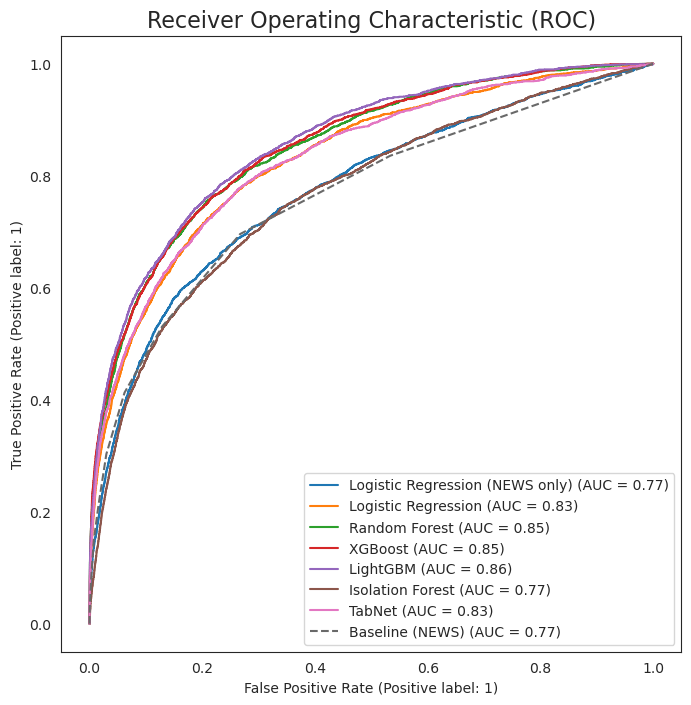

In [60]:
joint_plot(
    roc_dict,
    filename=f"{Notebook.IMAGE_DIR}/combined_roc_curve"
    if Notebook.SAVE_IMAGES
    else None,
    ax=None,
    title="Receiver Operating Characteristic (ROC)",
)


### Precision-Recall

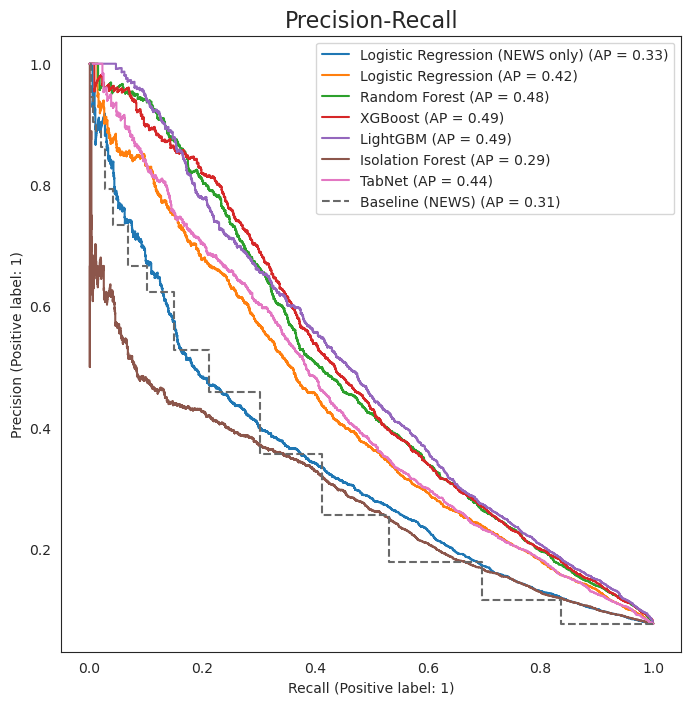

In [61]:
joint_plot(
    pr_dict,
    filename=f"{Notebook.IMAGE_DIR}/combined_pr_curve"
    if Notebook.SAVE_IMAGES
    else None,
    ax=None,
    title="Precision-Recall",
    legend_location="upper right",
)


### Side-by-side

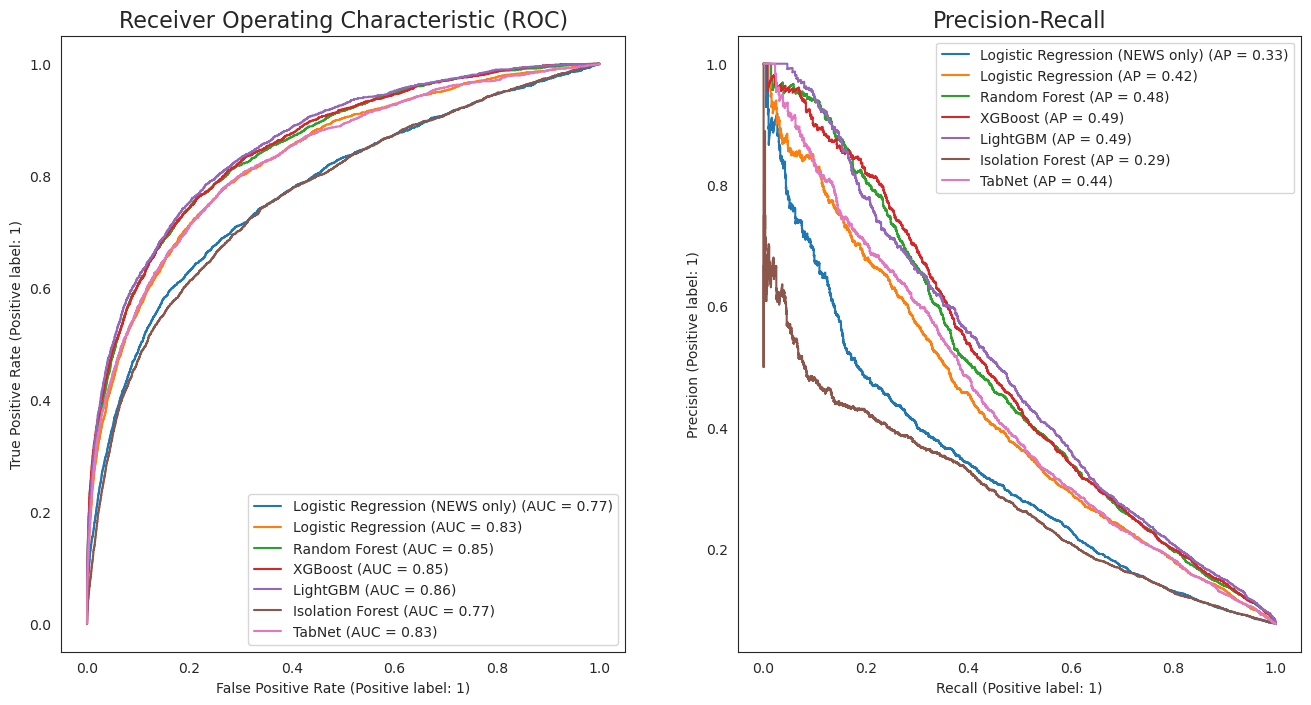

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
joint_plot(
    pr_dict,
    ax=ax[1],
    title="Precision-Recall",
    legend_location="upper right",
    plot_baseline=False,
)
joint_plot(
    roc_dict,
    ax=ax[0],
    title="Receiver Operating Characteristic (ROC)",
    plot_baseline=False,
)

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/combined_curves_no_baseline.png", bbox_inches="tight"
    )



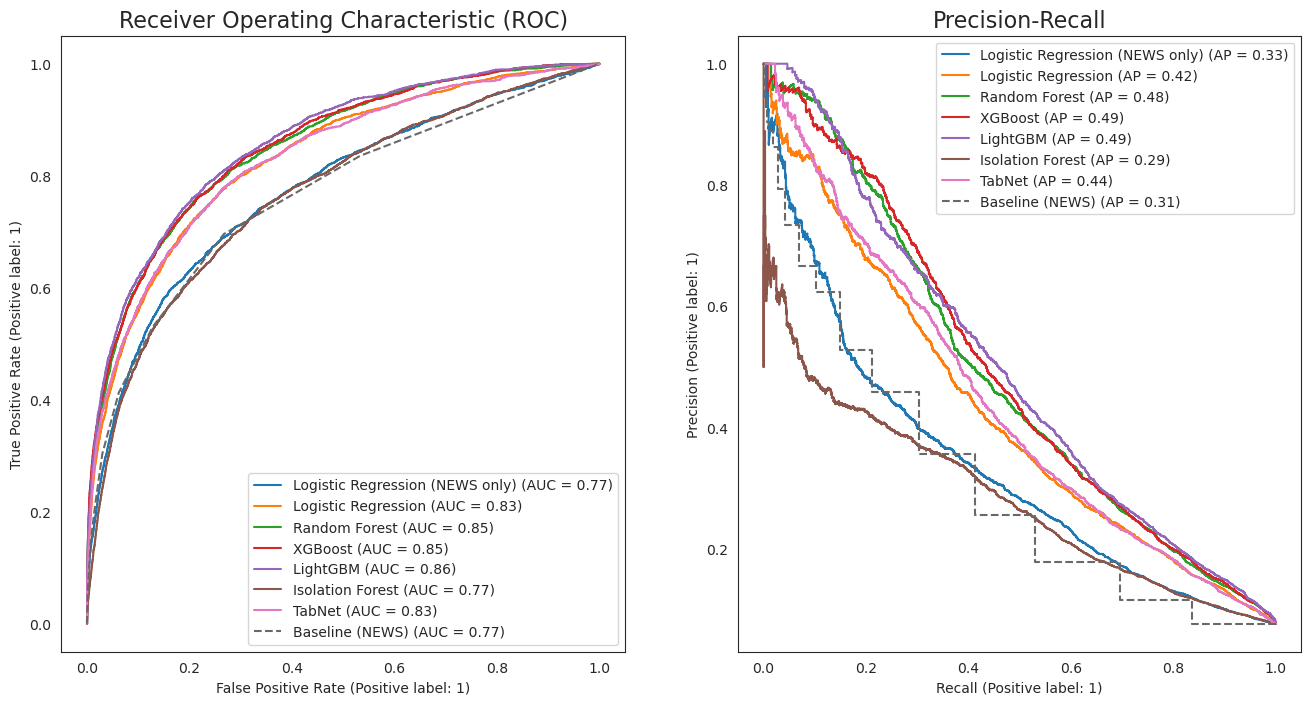

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
joint_plot(
    pr_dict, ax=ax[1], title="Precision-Recall", legend_location="upper right",
)
joint_plot(
    roc_dict, ax=ax[0], title="Receiver Operating Characteristic (ROC)",
)

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/combined_curves.png", bbox_inches="tight")


### SHAP Explanations (Setup - skip to next section)

In [64]:
y_preds = pd.DataFrame(
    {
        key: model.predict(
            {
                "LightGBM": X_test,
                "Isolation Forest": X_test_if,
                "TabNet": X_test.to_numpy(),
                "XGBoost": X_test,
                "Random Forest": X_test,
                "Logistic Regression": X_test,
            }[key]
        )
        for key, model in Notebook.MODELS.items()
        if key != "Logistic Regression (NEWS only)"
    }
)

candidates = y_preds[y_preds.all(axis=1)].index

patient = candidates[0]
patient_data = X_test.iloc[patient].apply(
    lambda x: f"{x:.2f}" if type(x) == np.float64 else x
)
patient_data_if = X_test_if.iloc[patient].copy()
patient_data_if.update(X_test.iloc[patient])

explanations = {
    modelkey: shap_values[patient]
    for modelkey, (_, shap_values) in Notebook.EXPLAINERS.items()
    if not modelkey in ["TabNet", "Logistic Regression (NEWS only)"]
}
for _ in explanations.keys():
    if len(explanations[_].shape) > 1:
        explanations[_] = explanations[_][:, 1]

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")

    tabnet_explainer = Notebook.EXPLAINERS["TabNet"][0]
    explanations["TabNet"] = shap.Explanation(
        tabnet_explainer.shap_values(X_test.to_numpy()[patient])[1],
        data=patient_data.values,
        base_values=tabnet_explainer.expected_value[1],
        feature_names=patient_data.index,
    )



### SHAP Force Plots

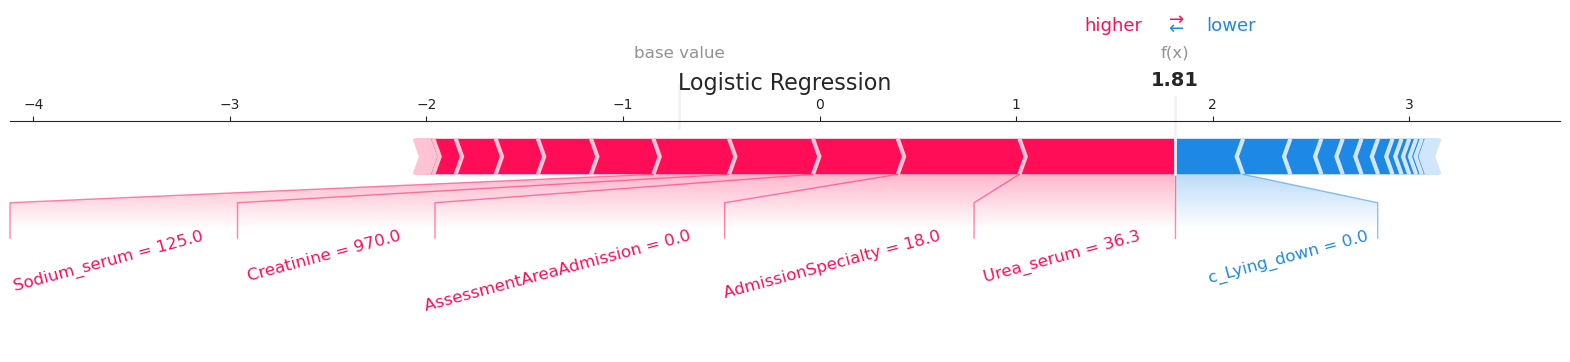

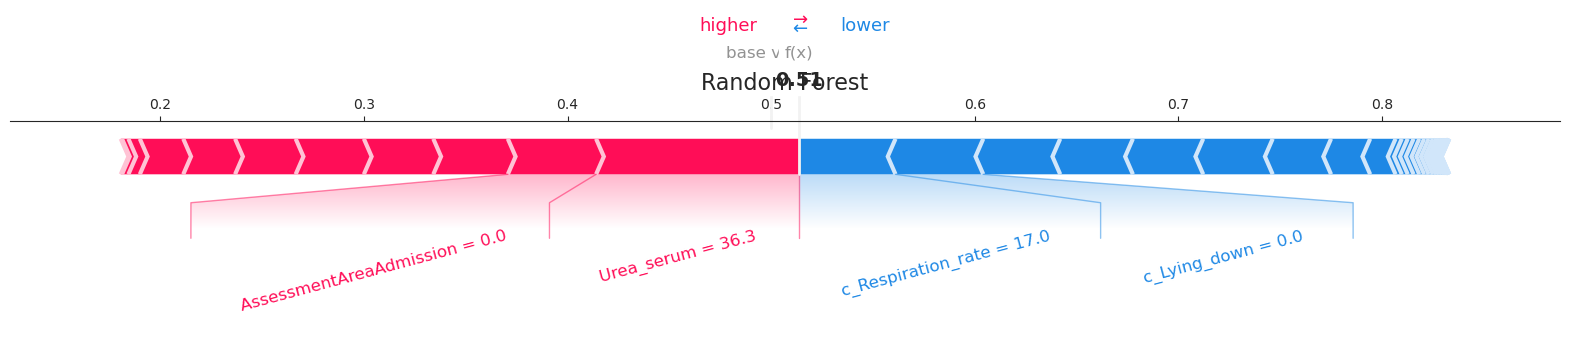

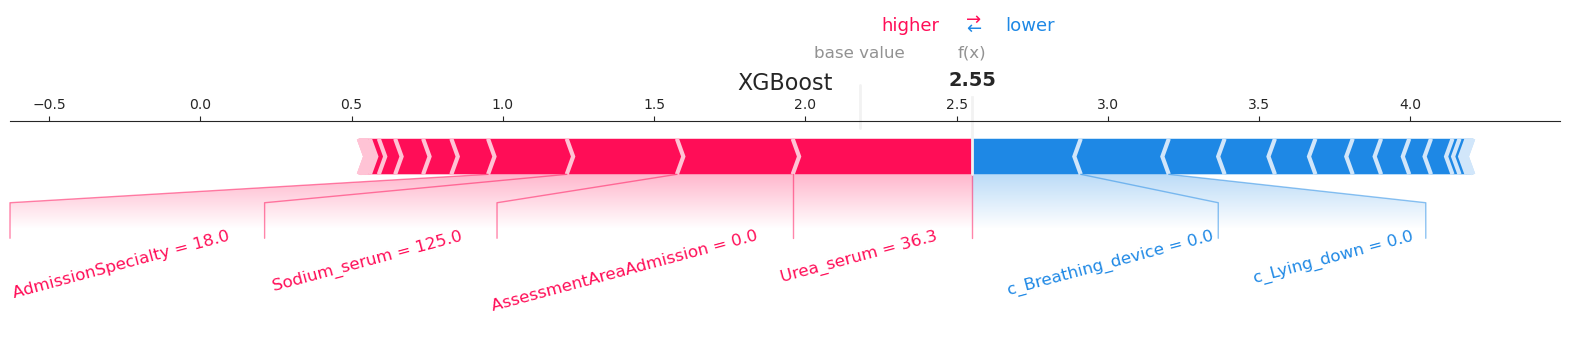

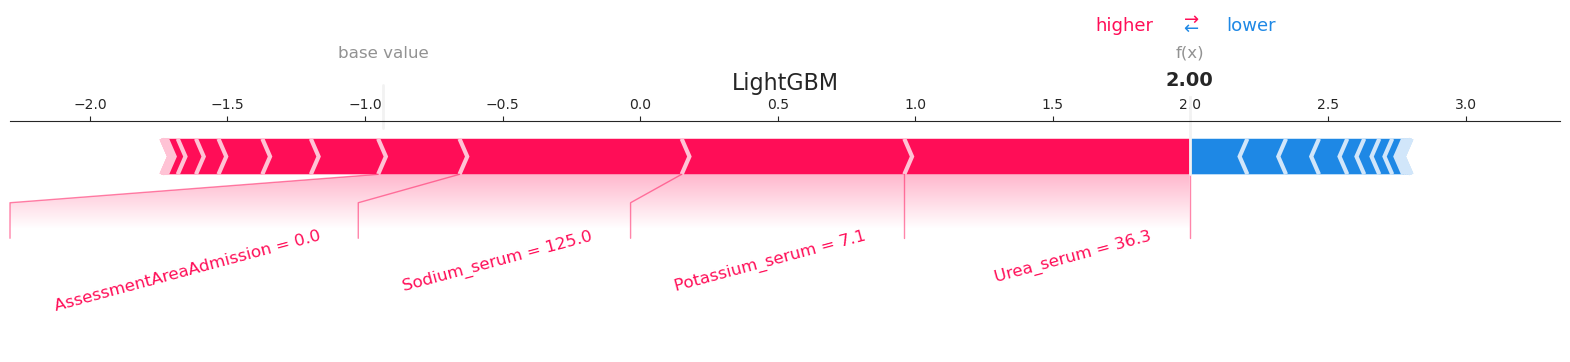

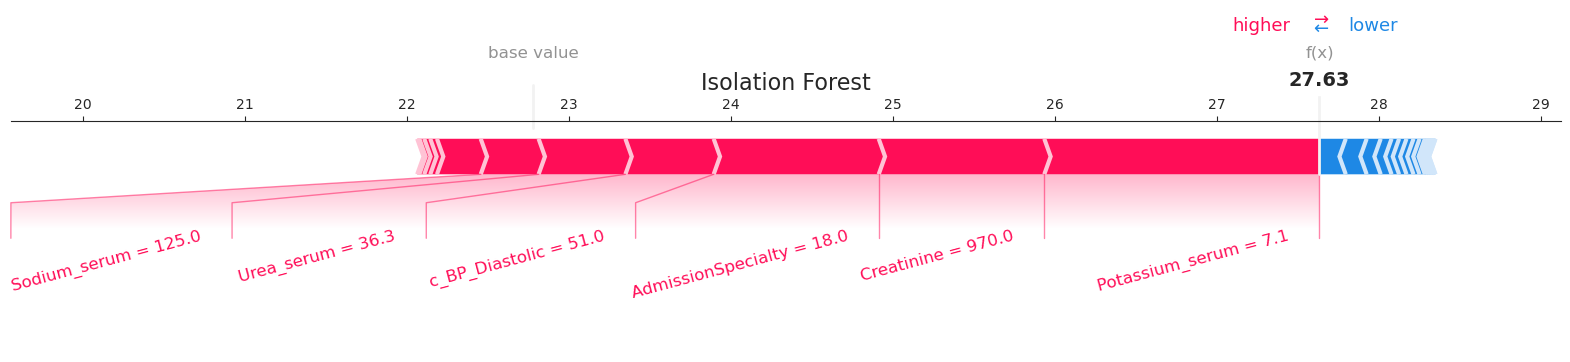

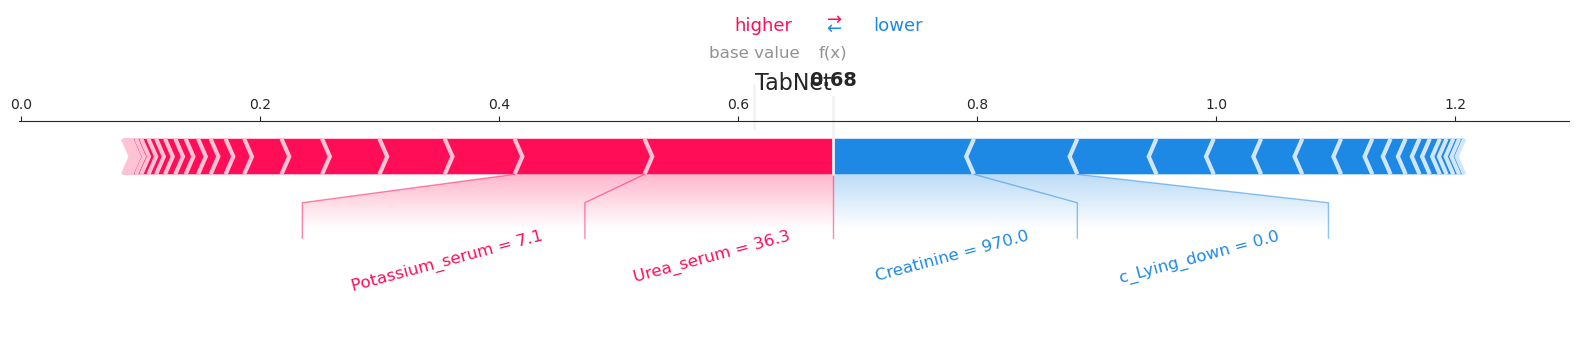

In [65]:
sns.set_style("white")
plt.rc("axes", titlesize=16)
for modelkey, explanation in explanations.items():
    patient_to_use = patient_data if modelkey != "Isolation Forest" else patient_data_if

    explanation = shap.Explanation(explanation)
    explanation.data = patient_to_use.values

    fig = shap.plots.force(
        explanation,
        feature_names=patient_to_use.index,
        matplotlib=True,
        contribution_threshold=0.08,
        show=False,
        text_rotation=15,
    )

    plt.title(modelkey)
    display(fig)

    if Notebook.SAVE_IMAGES:
        plt.savefig(
            f"{Notebook.IMAGE_DIR}/comaprison_force_plot_{modelkey.replace(' ','')}.png",
            bbox_inches="tight",
        )

    plt.clf()

sns.set_style("darkgrid")



### Mortality-only Results

In [66]:
pd.concat(
    [
        results[0].assign(Model=key)
        for key, results in Notebook.MORTALITY_RESULTS.items()
    ]
).set_index("Model")



Accuracy  Precision    Recall  F1 Score  \
Model                                                                      
Baseline (NEWS)                  0.947159   0.466893  0.166667  0.245645   
Logistic Regression (NEWS only)  0.514391   0.082973  0.836364  0.150968   
Logistic Regression              0.635840   0.109094  0.844848  0.193235   
Random Forest                    0.919597   0.298775  0.413939  0.347053   
XGBoost                          0.097109   0.054081  1.000000  0.102612   
LightGBM                         0.662464   0.118477  0.860000  0.208263   
Isolation Forest                 0.448160   0.073194  0.830909  0.134537   
TabNet                           0.715430   0.130288  0.795152  0.223891   

                                 F2 Score       AUC       AUC_CI  
Model                                                             
Baseline (NEWS)                  0.191264  0.765871  0.752-0.779  
Logistic Regression (NEWS only)  0.297004  0.774240  0.762-0.787  
Logistic Regression              0.359686  0.832105  0.822-0.842  
Random Forest                    0.384312  0.839977  0.830-0.849  
XGBoost                          0.222312  0.849672  0.841-0.858  
LightGBM                         0.381924  0.850023  0.841-0.859  
Isolation Forest                 0.270617  0.731691  0.718-0.745  
TabNet                           0.393521  0.828335  0.818-0.838

In [67]:
roc_dict, pr_dict = (
    {key: val[1] for key, val in Notebook.MORTALITY_RESULTS.items()},
    {key: val[2] for key, val in Notebook.MORTALITY_RESULTS.items()},
)

joint_plot(
    roc_dict,
    filename=f"{Notebook.IMAGE_DIR}/combined_roc_curve_mortality"
    if Notebook.SAVE_IMAGES
    else None,
    ax=None,
    title="Receiver Operating Characteristic (predicting mortality only)",
)

joint_plot(
    pr_dict,
    filename=f"{Notebook.IMAGE_DIR}/combined_pr_curve_mortality"
    if Notebook.SAVE_IMAGES
    else None,
    ax=None,
    title="Precision-Recall (predicting mortality only)",
    legend_location="upper right",
)

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
joint_plot(
    pr_dict, ax=ax[1], title="Precision-Recall", legend_location="upper right",
)
joint_plot(
    roc_dict, ax=ax[0], title="Receiver Operating Characteristic (ROC)",
)

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/combined_curves_mortality.png", bbox_inches="tight"
    )


### Critical care-only results

In [68]:
roc_dict, pr_dict = (
    {key: val[1] for key, val in Notebook.CRITICALCARE_RESULTS.items()},
    {key: val[2] for key, val in Notebook.CRITICALCARE_RESULTS.items()},
)

joint_plot(
    roc_dict,
    filename=f"{Notebook.IMAGE_DIR}/combined_roc_curve_criticalcare"
    if Notebook.SAVE_IMAGES
    else None,
    ax=None,
    title="Receiver Operating Characteristic (predicting critical care only)",
)

joint_plot(
    pr_dict,
    filename=f"{Notebook.IMAGE_DIR}/combined_pr_curve_criticalcare"
    if Notebook.SAVE_IMAGES
    else None,
    ax=None,
    title="Precision-Recall (predicting critical care only)",
    legend_location="upper right",
)

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
joint_plot(
    pr_dict, ax=ax[1], title="Precision-Recall", legend_location="upper right",
)
joint_plot(
    roc_dict, ax=ax[0], title="Receiver Operating Characteristic (ROC)",
)

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/combined_curves_criticalcare.png", bbox_inches="tight"
    )
